In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Statistic
from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency

# Libary for data prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer

# Library for modeling and evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error

import pickle


In [2]:
sns.set_theme(style="white", palette="dark:#5A9_r")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
def check_outliers(df, cols):
    summary = pd.DataFrame(columns=['Column', 'Q1', 'Q3', 'IQR', 'Upper Bound', 'Lower Bound', 'Number of Outliers', 'Proportion of Outliers'])
    
    
    outlier_indices = set()
    
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        count = len(outliers)
        total = len(df)
        proportion = round(count / total *100, 2)

       
        summary = summary.append({
            'Column': col,
            'Q1': q1,
            'Q3': q3,
            'IQR': iqr,
            'Upper Bound': upper_bound,
            'Lower Bound': lower_bound,
            'Number of Outliers': count,
            'Proportion of Outliers': proportion
        }, ignore_index=True)


        outlier_indices.update(outliers.index)
    
   
    summary = summary.sort_values('Number of Outliers', ascending=False)
    
    return summary, list(outlier_indices)

def add_mean_median_annotations(ax, data):
    mean_val = np.mean(data)
    median_val = np.median(data)
    
    ax.axvline(mean_val, color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='red', linestyle='solid', linewidth=2, label=f'Median: {median_val:.2f}')
    ax.legend()


def vif(X) :
    vif = pd.DataFrame()
    vif['variabel'] = X.columns
    vif['vif'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

    return vif

def chi_square_test(cat_var, target_var):
    contingency_table = pd.crosstab(df[cat_var], df[target_var])
    chi2_stat, p, dof, ex = chi2_contingency(contingency_table)
    print(f'Chi-Square Test for {cat_var} and {target_var}:')
    print(f'Chi-Square Statistic = {chi2_stat}, p-value = {p}')
    alpha = 0.05
    
    if p < alpha:
        print(f'Result: Reject null hypothesis - Significant association between {cat_var} and {target_var}.\n')
    else:
        print(f'Result: Fail to reject null hypothesis - No significant association between {cat_var} and {target_var}.\n')
    
    return contingency_table

def cramers_v(contingency_table):
    chi2_stat = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2_stat/n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Business Understanding

Daegu is one of the metropolitan cities in South Korea, with an area of approximately 1,500 square kilometers, divided into nine districts. Daegu is well-known as an industrial city and is the fourth-largest city in South Korea after Seoul, Busan, and Incheon. The population of Daegu has been consistently increasing from 1950 to 2022, reaching around 2.5 million in 2022. This growth indicates a rising demand for housing in Daegu.

The increasing demand for housing in metropolitan cities can often become a challenge, as many individuals working in these cities require nearby accommodation to facilitate their daily activities. The demand for housing in metropolitan areas is primarily driven by the fact that most city areas have been converted into business and office zones, leading to limited residential land and making it difficult to build houses. One solution to address the housing problem is the development of apartments, as they generally require less land, making them suitable for residential purposes in metropolitan cities. Therefore, it is expected that the demand for apartments will continue to grow in the future.

For a property company, this situation represents a potential business opportunity. XYZ Company is a property company specializing in apartments in Korea. The company primarily engages in the buying and selling of apartments, with most of the purchased apartments being resold. In the process of purchasing apartments, the company typically hires third-party services to conduct price checks, which are used for price surveys and comparisons of prospective apartment purchases. For apartment sales, the pricing process is managed by an internal division within the company.

- [Daegu as a Metropolitan City](https://id.wikipedia.org/wiki/Kota_khusus_di_Korea_Selatan)
- [Daegu Population](https://id.zhujiworld.com/kr/1024714-daegu/#details)
- [Daegu Districts](https://www.daegu.go.kr/english/index.do?menu_id=00000767)
- [Characteristics of Daegu](https://www.cnnindonesia.com/gaya-hidup/20200221195028-269-476946/7-wisata-di-daegu-dari-pasar-tekstil-sampai-pasar-obat)


**Problem**

- The apartment price survey process is considered inefficient by the company, as it requires additional costs for hiring survey services, which can reduce profit margins when selling the purchased apartments.
- The determination of apartment prices sometimes results in apartments being underpriced or overpriced. Overpriced listings can lead to unsold apartments due to uncompetitive market prices, while underpriced listings result in suboptimal profits.

**Objective**

Based on the problems outlined above, the company needs a model that can estimate apartment prices, eliminating the need for third-party services. Additionally, the model should assist the company in determining appropriate sale prices for apartments, avoiding underpricing or overpricing.

**Analysis**

Therefore, an analysis of apartment data is required, focusing on prices and apartment characteristics that may influence pricing. The next step involves building a machine learning model, specifically using regression, to predict apartment prices. This model is expected to help the company in both comparing the prices of apartments to be purchased and setting the selling prices of apartments.

**Evaluation Metrics**

- Mean Absolute Error (MAE): Chosen for its low sensitivity to outliers and ease of interpretation -> smaller is better.
- Mean Absolute Percentage Error (MAPE): Useful for measuring the model's accuracy -> smaller is better.
- Mean Squared Log Error (MSLE): Suitable for predicting apartment prices, which typically have a relatively large price range. MSLE is appropriate for evaluating models with a wide range of values and will be used as a benchmark for model comparison -> smaller is better.


# Data Understanding

The data used consists of characteristics of apartments in Daegu, encompassing a variety of variables. The variables are as follows:

|No|Variable Name|Description
|---|---|---|
|1|HallwayType|Type of apartment
|2|TimeToSubway|Time required to reach the nearest subway station
|3|SubwayStation|Name of the nearest subway station
|4|N_FacilitiesNearBy(ETC)|Number of nearby facilities
|5|N_FacilitiesNearBy(PublicOffice)|Number of nearby public facilities
|6|N_SchoolNearBy(University)|Number of nearby universities
|7|N_Parkinglot(Basement)|Number of parking spaces|
|8|YearBuilt|Year the apartment was built|
|9|N_FacilitiesInApt|Number of facilities in the apartment|
|10|Size(sqf)|Size of the apartment (in square feet)|
|11|SalePrice|Apartment price (in Won)|


Each row of the data represents an apartment unit. Since the objective of this analysis is to predict the price, the variable SalePrice will be the target variable, while the other variables will serve as features.

In [4]:
df= pd.read_csv('1. Daegu Apartment.csv')
df.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   HallwayType                       4123 non-null   object 
 1   TimeToSubway                      4123 non-null   object 
 2   SubwayStation                     4123 non-null   object 
 3   N_FacilitiesNearBy(ETC)           4123 non-null   float64
 4   N_FacilitiesNearBy(PublicOffice)  4123 non-null   float64
 5   N_SchoolNearBy(University)        4123 non-null   float64
 6   N_Parkinglot(Basement)            4123 non-null   float64
 7   YearBuilt                         4123 non-null   int64  
 8   N_FacilitiesInApt                 4123 non-null   int64  
 9   Size(sqf)                         4123 non-null   int64  
 10  SalePrice                         4123 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 354.4+ KB


In [6]:
df['YearBuilt'] = df['YearBuilt'].astype('str')

cat = df.columns[df.dtypes == object]
num = df.columns[df.dtypes != object]

print(cat, '\n', num)

Index(['HallwayType', 'TimeToSubway', 'SubwayStation', 'YearBuilt'], dtype='object') 
 Index(['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)',
       'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)',
       'N_FacilitiesInApt', 'Size(sqf)', 'SalePrice'],
      dtype='object')


## Category Variable

In [7]:
listItem = []
for col in df[cat].columns :
    listItem.append( [col, df[col].nunique(), df.sort_values(col)[col].unique()])

check_cat = pd.DataFrame(columns=['Name', 'N Unique', 'Data Unique'], data=listItem)

display(check_cat, df[cat].describe())

,Name,N Unique,Data Unique
0,HallwayType,3,"[corridor, mixed, terraced]"
1,TimeToSubway,5,"[0-5min, 10min~15min, 15min~20min, 5min~10min, no_bus_stop_nearby]"
2,SubwayStation,8,"[Bangoge, Banwoldang, Chil-sung-market, Daegu, Kyungbuk_uni_hospital, Myung-duk, Sin-nam, no_subway_nearby]"
3,YearBuilt,16,"[1978, 1980, 1985, 1986, 1992, 1993, 1997, 2003, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2015]"


,HallwayType,TimeToSubway,SubwayStation,YearBuilt
count,4123,4123,4123,4123
unique,3,5,8,16
top,terraced,0-5min,Kyungbuk_uni_hospital,2007
freq,2528,1953,1152,853


This dataset contains four categorical variables: HallwayType, which is of nominal categorical type; SubwayStation, which is also of nominal categorical type; YearBuilt, which is of ordinal categorical type; and TimeToSubway, which is of ordinal categorical type. Based on the results of the unique value check for each categorical variable, it is observed that there are no formatting issues.

TimeToSubway
1.  no_bus_stop_nearby
1.  0-5min
1.  5min~10min
1.  10min~15min
1.  15min~20min

YearBuilt	
1.  1978
1.  1980
1.  1985
1.  1986
1.  1992
1.  1993
1.  1997
1.  2003
1.  2005
1. 2006
1. 2007
1. 2008
1. 2009
1. 2013
1. 2014
1. 2015

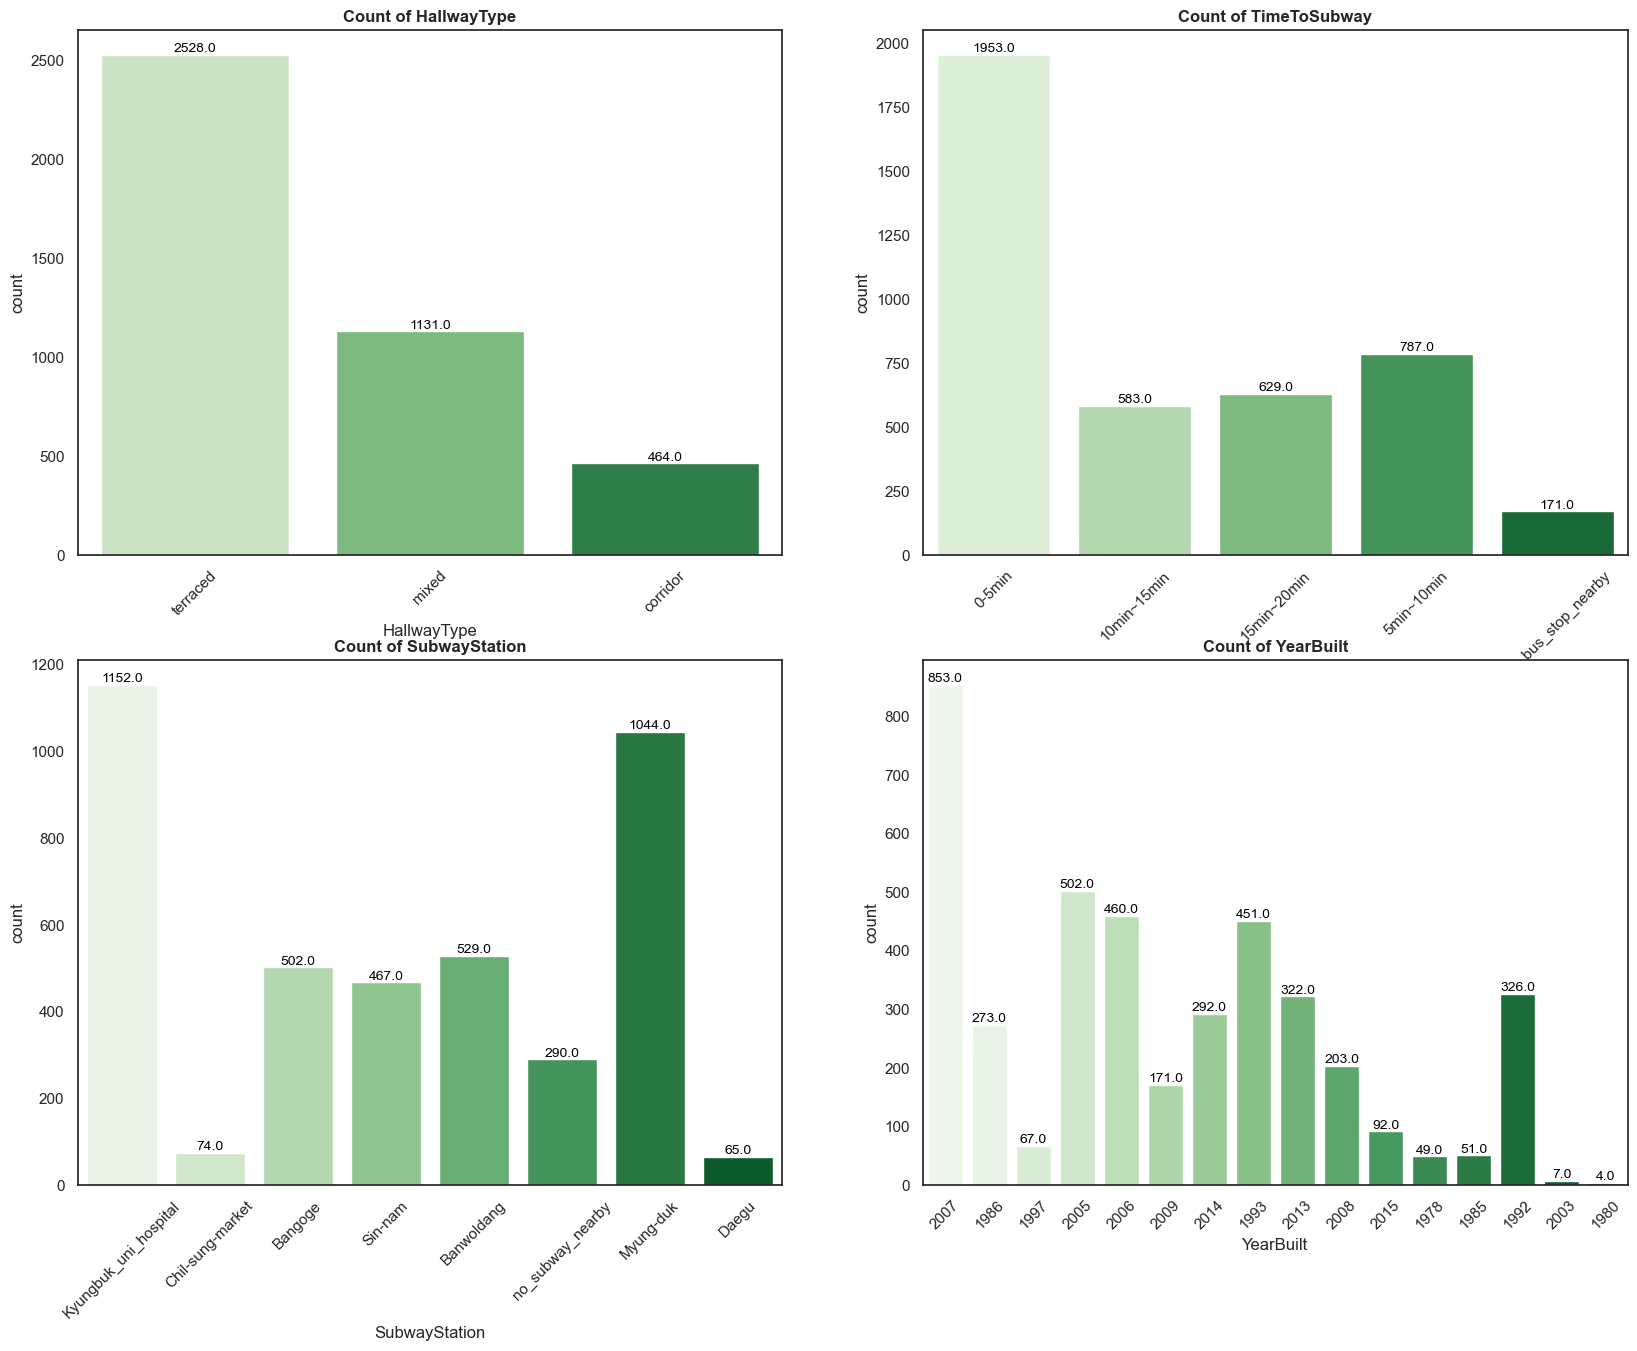

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, cat_var in enumerate(cat):

    ax = sns.countplot(x=cat_var, data=df, ax=axes[i], palette="Greens")
    ax.set_title(f'Count of {cat_var}', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

    for p in ax.patches:
        height = p.get_height()  
        ax.annotate(f'{height}',  
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom',  
                    fontsize=10, color='black') 

**Count of HallwayType** <br>
The majority of properties have a "terraced" hallway type (2,528), which significantly outnumbers the other types.
"Mixed" hallways are the second most common (1,131), followed by "corridor" hallways (454).
This suggests that "terraced" hallways are the preferred design or the most common type in the dataset.

**Count of TimeToSubway** <br>
Most properties are located within a 0-5 minute walk to a subway station (1,953), indicating that proximity to public transportation is a significant factor.
The next largest group is within a 5-10 minute walk (787). Properties farther away (10-15 min and 15-20 min) have fewer counts, and very few properties are located in areas with "bus stops nearby" (171).
This implies that the dataset may be skewed towards urban areas with good access to public transportation.

**Count of SubwayStation** <br>
Overall, the chart highlights the strong influence of proximity to subway stations on property distribution. Areas with convenient access to subway stations like "Kyungbok Univ. Hospital" and "Myeong-dok" are significantly more in demand, reflecting the critical role of public transportation in urban living preferences and property value in Daegu.

**Count of YearBuilt** <br>
The majority of properties were built in 2007 (853), indicating a significant construction boom around that year.
Another peak is seen 2005 and 2006 
This suggests a trend where older buildings (pre-1980s) are less common, and there was substantial construction between the 1980s to early 2000s, with a decline after 2013.

In [9]:
target_variable = 'SalePrice'

for cat_var in cat:
    chi_square_test(cat_var, target_variable)
    jutsu = chi_square_test

for cat_var in cat:
    contingency_table = pd.crosstab(df[cat_var], df[target_variable])
    cramer_v = cramers_v(contingency_table)
    print(f"Cramer's V for {cat_var} and {target_variable}: {cramer_v:.3f}")

Chi-Square Test for HallwayType and SalePrice:
Chi-Square Statistic = 4977.48521168038, p-value = 0.0
Result: Reject null hypothesis - Significant association between HallwayType and SalePrice.

Chi-Square Test for TimeToSubway and SalePrice:
Chi-Square Statistic = 7595.164977700998, p-value = 0.0
Result: Reject null hypothesis - Significant association between TimeToSubway and SalePrice.

Chi-Square Test for SubwayStation and SalePrice:
Chi-Square Statistic = 11029.351304868429, p-value = 0.0
Result: Reject null hypothesis - Significant association between SubwayStation and SalePrice.

Chi-Square Test for YearBuilt and SalePrice:
Chi-Square Statistic = 21878.58941244971, p-value = 0.0
Result: Reject null hypothesis - Significant association between YearBuilt and SalePrice.

Cramer's V for HallwayType and SalePrice: 0.777
Cramer's V for TimeToSubway and SalePrice: 0.679
Cramer's V for SubwayStation and SalePrice: 0.618
Cramer's V for YearBuilt and SalePrice: 0.595


**HallwayType and SalePrice** <br>
The Chi-Square test reveals a strong connection between the Hallway Type (terraced, mixed, corridor) and the Sale Price of properties. With a high Cramer's V value of 0.777, it’s clear that the hallway design significantly impacts property prices. 

**TimeToSubway and SalePrice** <br>
The test also shows a strong link between Time to Subway (distance to the nearest station) and Sale Price. The Cramer's V score of 0.679 suggests that properties closer to a subway station tend to sell for more. 

**SubwayStation and SalePrice** <br>
There’s a noticeable association between the Subway Station a property is near and its Sale Price. With a Cramer's V of 0.618, it's evident that some stations are more desirable than others, likely reflecting the quality or reputation of the neighborhoods around those stations. So, not just any proximity to a subway, but which subway station matters too.

**YearBuilt and SalePrice** <br>
Finally, there’s a moderate association between Year Built and Sale Price, as indicated by a Cramer's V value of 0.595. This shows that while newer properties may often be valued higher, it's not the only factor in determining price — location, design, and amenities seem to play bigger roles.

## Numerical Variable

In [10]:
listItem = []
for col in df[num].columns :
    listItem.append( [col, df[col].nunique(), df.sort_values(col)[col].unique()])

check_num = pd.DataFrame(columns=['Name', 'N Unique', 'Data Unique'], data=listItem)

display(check_num, df[num].describe())

,Name,N Unique,Data Unique
0,N_FacilitiesNearBy(ETC),4,"[0.0, 1.0, 2.0, 5.0]"
1,N_FacilitiesNearBy(PublicOffice),8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]"
2,N_SchoolNearBy(University),6,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]"
3,N_Parkinglot(Basement),20,"[0.0, 18.0, 56.0, 76.0, 79.0, 108.0, 181.0, 184.0, 203.0, 218.0, 400.0, 475.0, 524.0, 536.0, 605.0, 798.0, 930.0, 1174.0, 1270.0, 1321.0]"
4,N_FacilitiesInApt,9,"[1, 2, 3, 4, 5, 7, 8, 9, 10]"
5,Size(sqf),89,"[135, 138, 156, 160, 163, 192, 206, 213, 273, 277, 281, 288, 355, 426, 430, 451, 498, 508, 547, 558, 572, 576, 587, 636, 640, 644, 676, 736, 743, 779, 793, 811, 814, 818, 829, 832, 839, 843, 846, 857, 868, 871, 903, 907, 910, 914, 1035, 1060, 1085, 1088, 1092, 1103, 1131, 1149, 1160, 1167, 1184, 1192, 1252, 1256, 1273, 1288, 1291, 1313, 1327, 1334, 1366, 1369, 1377, 1387, 1394, 1412, 1419, 1437, 1444, 1448, 1451, 1483, 1519, 1629, 1643, 1690, 1743, 1761, 1796, 1928, 2056, 2092, 2337]"
6,SalePrice,838,"[32743, 34070, 34513, 35398, 35840, 36283, 37168, 37610, 37787, 38053, 38495, 38584, 38761, 38938, 39823, 40088, 41061, 42477, 43185, 43362, 44247, 44690, 46017, 46902, 47787, 48053, 48672, 49115, 49557, 49734, 51327, 52212, 53097, 53274, 53982, 54424, 54867, 55752, 56637, 57079, 57522, 57964, 58407, 58849, 59115, 59292, 59734, 59911, 60176, 60619, 60973, 61061, 61504, 61946, 62831, 63274, 63716, 64159, 64601, 65044, 65486, 65929, 66371, 66814, 67256, 68141, 68584, 69026, 69469, 69911, 70353, 70796, 71238, 71681, 72123, 72256, 72566, 72654, 72920, 73008, 73053, 73442, 73451, 73840, 73893, 74256, 74336, 74672, 74778, 74955, 75088, 75221, 75504, 75920, 76106, 76991, 77876, 78318, 78761, 79203, ...]"


,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),N_FacilitiesInApt,Size(sqf),SalePrice
count,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000
mean,1.930876,4.135338,2.746301,568.979141,5.817851,954.630851,221767.926995
std,2.198832,1.802640,1.496610,410.372742,2.340507,383.805648,106739.839945
min,0.000000,0.000000,0.000000,0.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,184.000000,4.000000,644.000000,144752.000000
50%,1.000000,5.000000,2.000000,536.000000,5.000000,910.000000,209734.000000
75%,5.000000,5.000000,4.000000,798.000000,7.000000,1149.000000,291150.000000
max,5.000000,7.000000,5.000000,1321.000000,10.000000,2337.000000,585840.000000


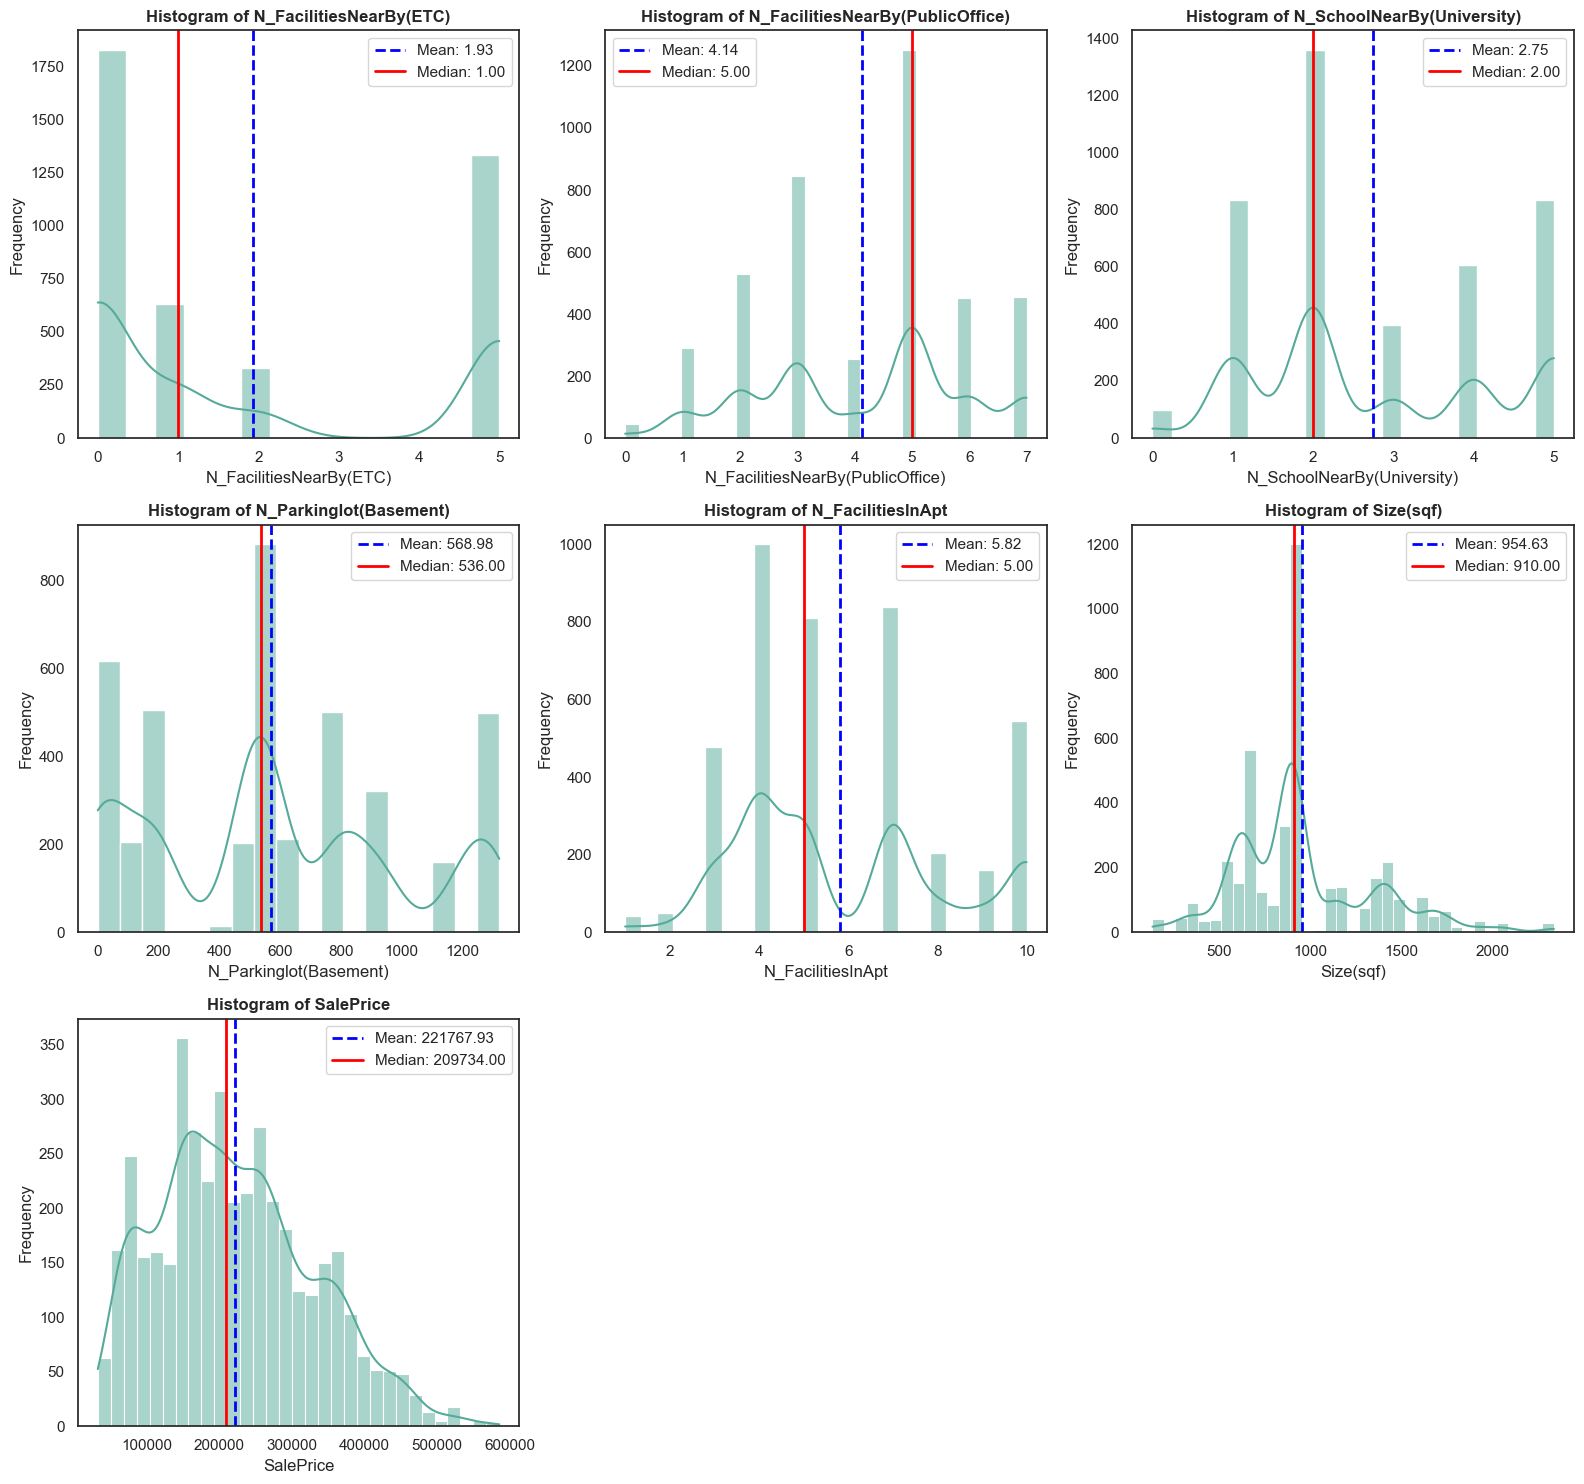

In [11]:
plt.figure(figsize=(16, 15))

for i, col in enumerate(num, 1):
    plt.subplot(3, 3, i)  
    ax = sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    add_mean_median_annotations(ax, df[col])

plt.tight_layout()
plt.show()

In [12]:
summary = pd.DataFrame()  
columns = []
p_values = []
results = []
counter = 0

for column in df[num].columns:  
    counter += 1
    columns.append(column)

    test_statistic, test_pvalue = normaltest(df[column])  

    if test_pvalue > 0.05:
        result = 'So, we assume a normal distribution'
        p_values.append(test_pvalue)
        results.append(result)
    else:
        result = 'So, we do not assume a normal distribution'
        p_values.append(test_pvalue)
        results.append(result)

    if counter == len(df[num].columns):  
        summary['Column'] = columns
        summary['P-Value'] = p_values
        summary['Result'] = results

summary 

,Column,P-Value,Result
0,N_FacilitiesNearBy(ETC),0.000000e+00,"So, we do not assume a normal distribution"
1,N_FacilitiesNearBy(PublicOffice),4.080101e-135,"So, we do not assume a normal distribution"
2,N_SchoolNearBy(University),0.000000e+00,"So, we do not assume a normal distribution"
3,N_Parkinglot(Basement),1.054470e-182,"So, we do not assume a normal distribution"
4,N_FacilitiesInApt,2.876296e-135,"So, we do not assume a normal distribution"
5,Size(sqf),1.106320e-101,"So, we do not assume a normal distribution"
6,SalePrice,3.212361e-35,"So, we do not assume a normal distribution"


**N_FacilitiesNearBy(ETC)** histogram shows that most locations having very few (0-1) "ETC" facilities nearby. Only a handful of locations have more than that. The mean (1.93) is slightly above the median (1), which suggests that a small number of places have more of these facilities, but they are outliers.
This indicates that it's rare for locations to have more than 1 or 2 of these additional facilities.

**N_FacilitiesNearBy(PublicOffice)** histogram peaking at 5 facilities, with the mean slightly lower than the median. The data suggests that while many locations are well-served by public offices (around 5 nearby), there are several with fewer, which brings the average down.

**N_SchoolNearBy(University)** histogram shows that most locations having around 2 universities nearby.

**N_Parkinglot(Basement)** distribution is multimodal, with multiple peaks around 200, 400, and 600 parking spots. The presence of multiple peaks suggests different categories or building types with varying basement parking capacities.

**N_FacilitiesInApt** histogram shows that most apartments having around 5 facilities.

**Size(sqf)** histogram shows a right-skewed distribution, with most apartments around 910 sq ft, but some larger ones pulling the mean up. The average size (954.63 sq ft) is somewhat higher than the median (910 sq ft), reflecting a few bigger apartments in the data. Given that most apartments fall in the 900-1000 sq ft range, this is likely the sweet spot for developers and marketers. Larger units may cater to a more niche market.

**SalePrice** histogram shows a pronounced right skew, with most properties at the lower end of the price scale and a few outliers at higher prices. The average sale price (221,767.93) is noticeably higher than the median (209,734), which suggests a few high-value sales are driving the mean up. The bulk of sales are in the lower to mid-price range, making this the primary market segment. Consider that most transactions will likely occur within the more affordable range, but there’s also an opportunity to cater to high-end buyers with luxury offerings.

Many of the variables show skewness, indicating non-normal distributions and the presence of outliers. This affects how averages should be interpreted, with the median often being a more reliable central value. Some variables, like basement parking, show multiple peaks, suggesting distinct clusters within the data. This could be useful for segmentation strategies

In [13]:
outlier_recap = check_outliers(df, num)[0]
outlier_recap

,Column,Q1,Q3,IQR,Upper Bound,Lower Bound,Number of Outliers,Proportion of Outliers
5,Size(sqf),644.0,1149.0,505.0,1906.5,-113.5,98,2.38
6,SalePrice,144752.0,291150.0,146398.0,510747.0,-74845.0,27,0.65
0,N_FacilitiesNearBy(ETC),0.0,5.0,5.0,12.5,-7.5,0,0.00
1,N_FacilitiesNearBy(PublicOffice),3.0,5.0,2.0,8.0,0.0,0,0.00
2,N_SchoolNearBy(University),2.0,4.0,2.0,7.0,-1.0,0,0.00
3,N_Parkinglot(Basement),184.0,798.0,614.0,1719.0,-737.0,0,0.00
4,N_FacilitiesInApt,4.0,7.0,3.0,11.5,-0.5,0,0.00


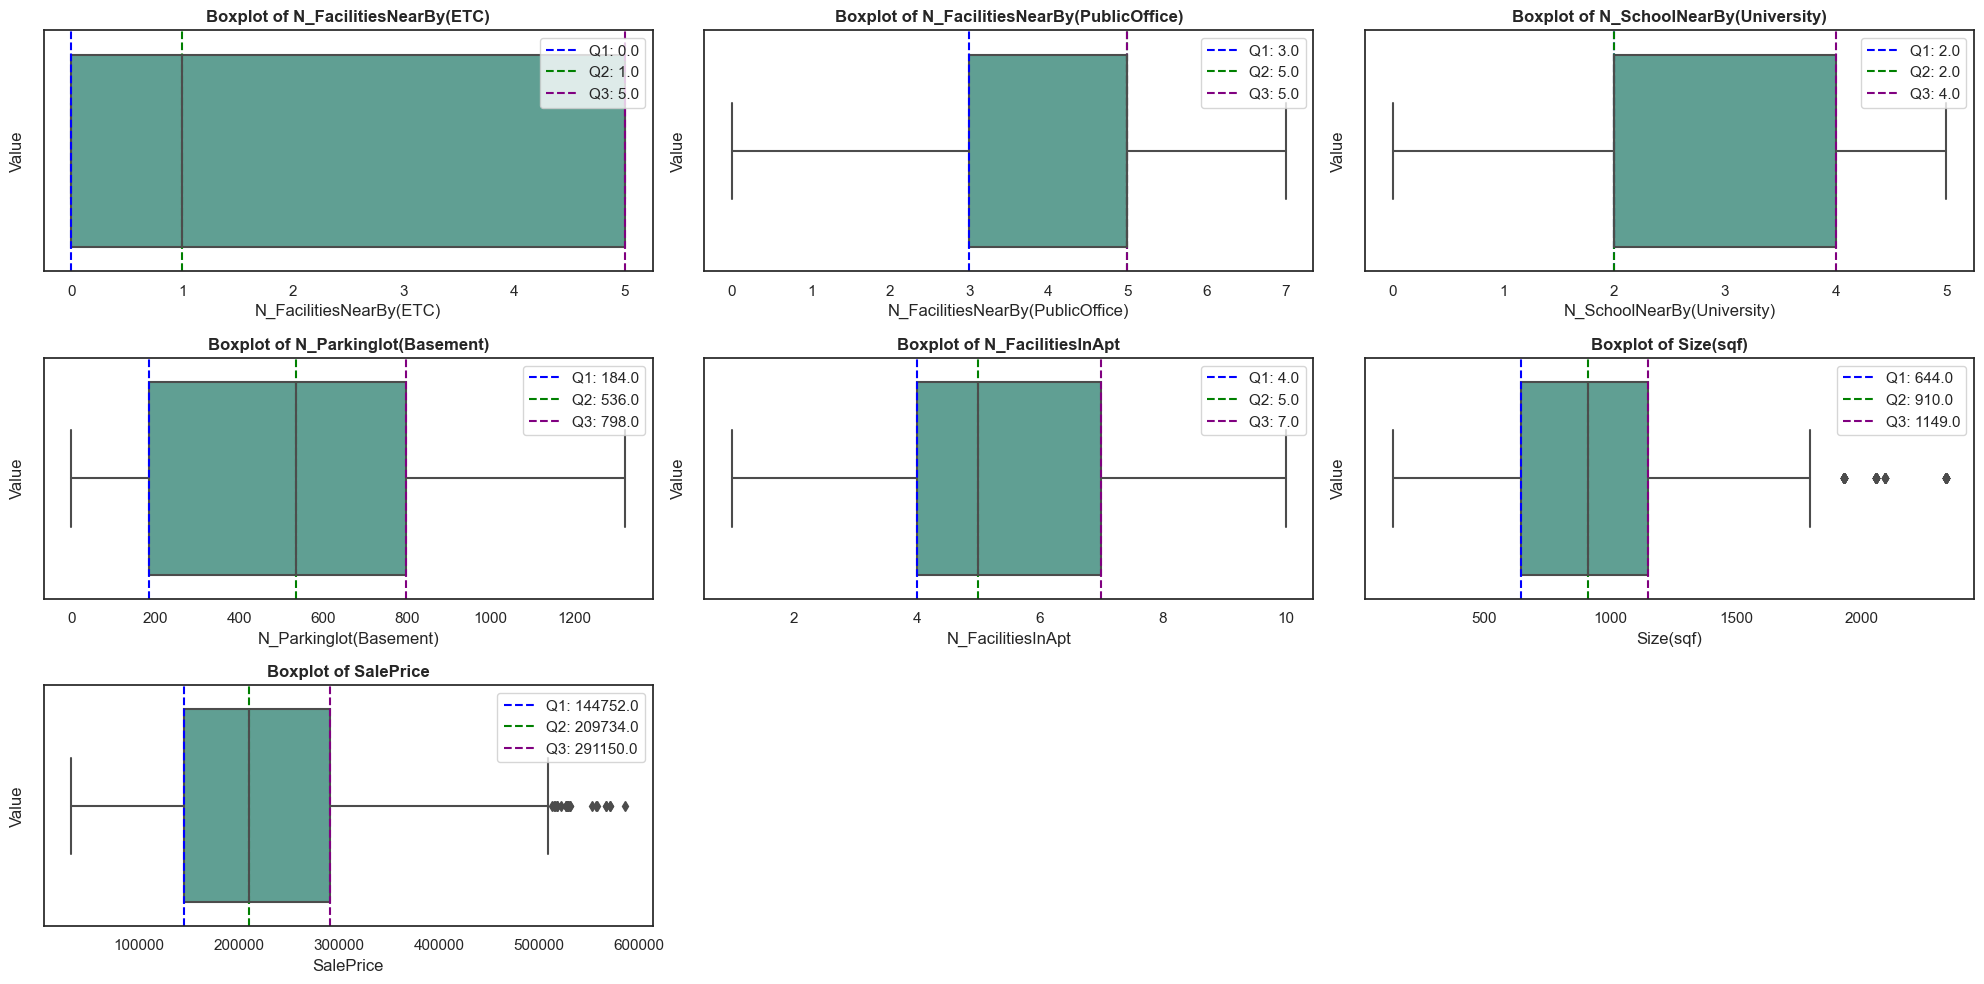

In [14]:
plt.figure(figsize=(20,10))

for i, col in enumerate(num, 1):

    plt.subplot(3, 3, i)  
    ax = sns.boxplot(x=df[col])

    Q1 = df[col].quantile(0.25)
    Q2 = df[col].median() 
    Q3 = df[col].quantile(0.75)

    plt.axvline(Q1, color='blue', linestyle='--', label=f'Q1: {Q1}')
    plt.axvline(Q2, color='green', linestyle='--', label=f'Q2: {Q2}')
    plt.axvline(Q3, color='purple', linestyle='--', label=f'Q3: {Q3}')

    plt.legend(loc='upper right')
    plt.title(f'Boxplot of {col}', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

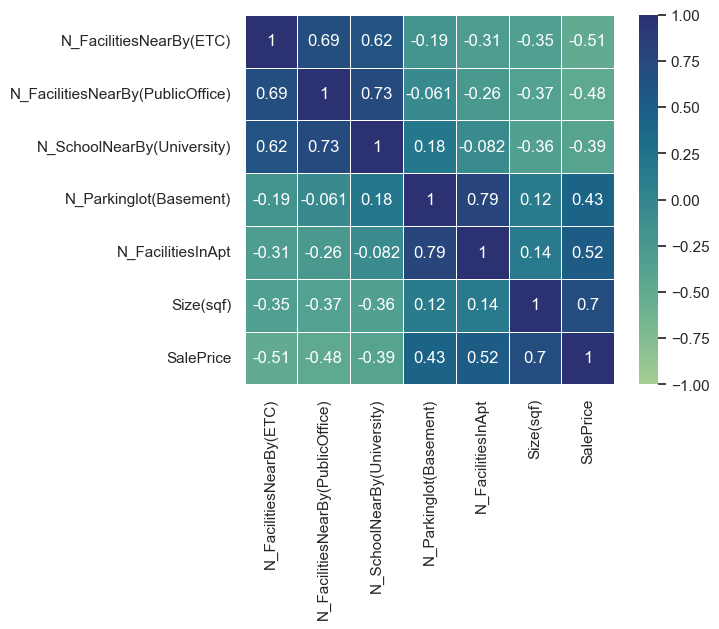

In [15]:
sns.heatmap(df.corr(method='spearman'), cmap="crest", annot=True, square=True, vmin=-1, linewidth=.5)
plt.show()

**Size(sqf) and SalePrice (Correlation: 0.70)** <br>
There is a strong positive correlation between the size of the property (in square feet) and its sale price. This suggests that as the size of a property increases, its sale price tends to be higher. Larger properties are generally more valuable, likely due to offering more living space, which is attractive to most buyers. However, while this correlation suggests a strong relationship, it does not imply that increasing the size alone will always cause a proportional increase in price. Other factors, like location or amenities, can also play a role. Focusing on larger units might help achieve higher sale prices, but consider additional market factors that might affect price.

**N_FacilitiesInApt and SalePrice (Correlation: 0.52)** <br>
There is a moderate positive correlation between the number of facilities within an apartment and its sale price. Apartments with more internal facilities (such as gyms, swimming pools, and security systems) tend to have higher sale prices.  More facilities generally make a property more attractive to potential buyers, as they add convenience, luxury, and value to the living experience. However, while the correlation is moderate, it doesn't mean that every additional facility directly results in a higher sale price — the type and quality of facilities also matter. 

**N_Parkinglot(Basement) and SalePrice (Correlation: 0.43)** <br>
There is a moderate positive correlation between the number of parking spaces in the basement and sale price. Properties with more parking spaces tend to sell for higher prices. In urban areas where parking is limited, having ample parking is a desirable feature that adds convenience and security, thus increasing a property's attractiveness and, consequently, its sale price. However, the moderate correlation does not prove that more parking always causes a significant price increase.

**N_FacilitiesNearBy(ETC), N_FacilitiesNearBy(PublicOffice), and N_SchoolNearBy(University) and SalePrice (Negative Correlations: -0.51, -0.48, and -0.39, respectively)** <br>
These three variables the number of miscellaneous facilities, public offices, and universities nearby, all show negative correlations with SalePrice.  This suggests that properties with a higher number of nearby facilities tend to have lower sale prices. This could mean that such facilities are more often located in less desirable areas for residential properties, such as busier or more crowded zones. 

**Positive correlations** (e.g., Size, Facilities in Apt, Parking) suggest that factors providing direct benefits or convenience to the buyer (like more space, amenities, and parking) are associated with higher sale prices.

**Negative correlations** (e.g., proximity to external facilities) indicate that factors that might contribute to noise, crowding, or less desirable environments could be linked to lower sale prices.

The heatmap reveals potential multicollinearity issues among several predictor variables. To build a robust and interpretable model for predicting SalePrice, it is crucial to assess multicollinearity and take appropriate steps to address it.

In [16]:
check_vif = df[num].drop(['SalePrice'], axis=1)
vif(check_vif).sort_values('vif', ascending=False)

,variabel,vif
2,N_SchoolNearBy(University),16.836527
4,N_FacilitiesInApt,16.028845
1,N_FacilitiesNearBy(PublicOffice),12.969386
3,N_Parkinglot(Basement),9.435882
0,N_FacilitiesNearBy(ETC),5.258321
5,Size(sqf),5.211340


Based on the VIF results, the variables N_SchoolNearBy(University), N_FacilitiesInApt, and N_FacilitiesNearBy(PublicOffice) have VIF values greater than 10, indicating a serious multicollinearity issue. Therefore, this will need to be addressed during the data preparation stage.

# Data Preparation

In [17]:
df_prep = df.copy()
df_prep

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,323008
4119,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,242477
4120,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4121,corridor,5min~10min,Daegu,2.0,5.0,0.0,76.0,1985,3,676,73451


## Outlier

Based on the findings from the data understanding phase, it was determined that only two variables contain outliers. Removing these outliers is still considered realistic due to their relatively small number, meaning that minimal information would be lost. However, it is recognized that these outliers are caused by existing conditions, making the values still realistic. Therefore, in this case, the outliers will not be removed.

## Feature Selection

Based on the results of the correlation coefficients and VIF values, multicollinearity was found among the numerical variables. Therefore, in this case, an attempt will be made to remove the variables one by one until no multicollinearity is present.

In [18]:
vif(check_vif.drop(['N_Parkinglot(Basement)'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
2,N_SchoolNearBy(University),15.165116
1,N_FacilitiesNearBy(PublicOffice),11.538953
3,N_FacilitiesInApt,5.761597
0,N_FacilitiesNearBy(ETC),5.207005
4,Size(sqf),5.122661


In [19]:
vif(check_vif.drop(['N_Parkinglot(Basement)','N_FacilitiesNearBy(PublicOffice)'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
1,N_SchoolNearBy(University),10.027453
2,N_FacilitiesInApt,5.708161
0,N_FacilitiesNearBy(ETC),5.096089
3,Size(sqf),4.734995


In [20]:
vif(check_vif.drop(['N_Parkinglot(Basement)','N_FacilitiesNearBy(PublicOffice)','N_SchoolNearBy(University)'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
1,N_FacilitiesInApt,4.707423
2,Size(sqf),4.456734
0,N_FacilitiesNearBy(ETC),1.467994


Based on the VIF check results, after removing the variables N_Parkinglot(Basement), N_FacilitiesNearBy(PublicOffice), and N_SchoolNearBy(University), the VIF values became relatively low (<10), indicating that there is no serious multicollinearity issue.

In [21]:
df_prep.drop(['N_Parkinglot(Basement)','N_FacilitiesNearBy(PublicOffice)','N_SchoolNearBy(University)'], axis = 1, inplace = True)

## Encoding

In [22]:
ordinal = [
    {'col':'TimeToSubway',
    'mapping':{'no_bus_stop_nearby' : 0,
    '0-5min' : 1,
    '10min~15min' : 2,
    '15min~20min' : 3,
    }},
    
    {'col':'YearBuilt',
    'mapping':{'1978' : 0,
    '1980' : 1,
    '1985' : 2,
    '1986' : 3,
    '1992' : 4,
    '1993' : 5,
    '1997' : 6,
    '2003' : 7,
    '2005' : 8,
    '2006' : 9,
    '2007' : 10,
    '2008' : 11,
    '2009' : 12,
    '2013' : 13,
    '2014' : 14,
    '2015' : 15,
    }},
]

ohe = OneHotEncoder(drop='first')
ohe_var = ['HallwayType','SubwayStation']

ordinal_var = ['TimeToSubway','YearBuilt']

transformer = ColumnTransformer([
    ('ohe', ohe, ohe_var),
    ('ordinal',ce.OrdinalEncoder(mapping= ordinal), ordinal_var)
], remainder='passthrough')

## Split Data

In [23]:
X = df_prep.drop('SalePrice', axis=1)
y = df_prep['SalePrice']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

display(X_trainval,
        X_test,
        y_trainval,
        y_test)

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf)
1146,mixed,15min~20min,Myung-duk,5.0,1993,4,2337
2984,terraced,0-5min,Banwoldang,0.0,2007,5,1334
3889,mixed,15min~20min,Myung-duk,5.0,1993,4,914
2825,terraced,5min~10min,no_subway_nearby,0.0,2015,10,644
1921,terraced,0-5min,Sin-nam,0.0,2008,8,829
...,...,...,...,...,...,...,...
3444,corridor,5min~10min,Banwoldang,0.0,2014,2,213
466,corridor,5min~10min,Banwoldang,0.0,2014,2,288
3092,mixed,5min~10min,Bangoge,5.0,2005,7,914
3772,mixed,15min~20min,Myung-duk,5.0,1993,4,1288


,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf)
1618,terraced,0-5min,Kyungbuk_uni_hospital,0.0,2013,7,910
893,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,1986,4,914
309,corridor,5min~10min,Daegu,2.0,1985,3,676
1877,terraced,0-5min,Kyungbuk_uni_hospital,0.0,2007,10,1643
1189,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,1986,4,1131
...,...,...,...,...,...,...,...
479,mixed,5min~10min,Bangoge,5.0,2005,7,914
3981,mixed,5min~10min,Bangoge,5.0,2005,7,572
1592,mixed,15min~20min,Myung-duk,1.0,1992,3,644
838,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,2006,5,910


1146    212389
2984    357522
3889    172566
2825    287610
1921    252212
         ...  
3444     74955
466     104424
3092    263716
3772    181415
860     201769
Name: SalePrice, Length: 3298, dtype: int64

1618    255442
893     184955
309      70796
1877    515929
1189    150442
         ...  
479     173451
3981    107964
1592     82300
838     181415
1891    144752
Name: SalePrice, Length: 825, dtype: int64

# Data Analysis

In [24]:
df_prep.head(3)

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,1997,5,558,61946


## Price

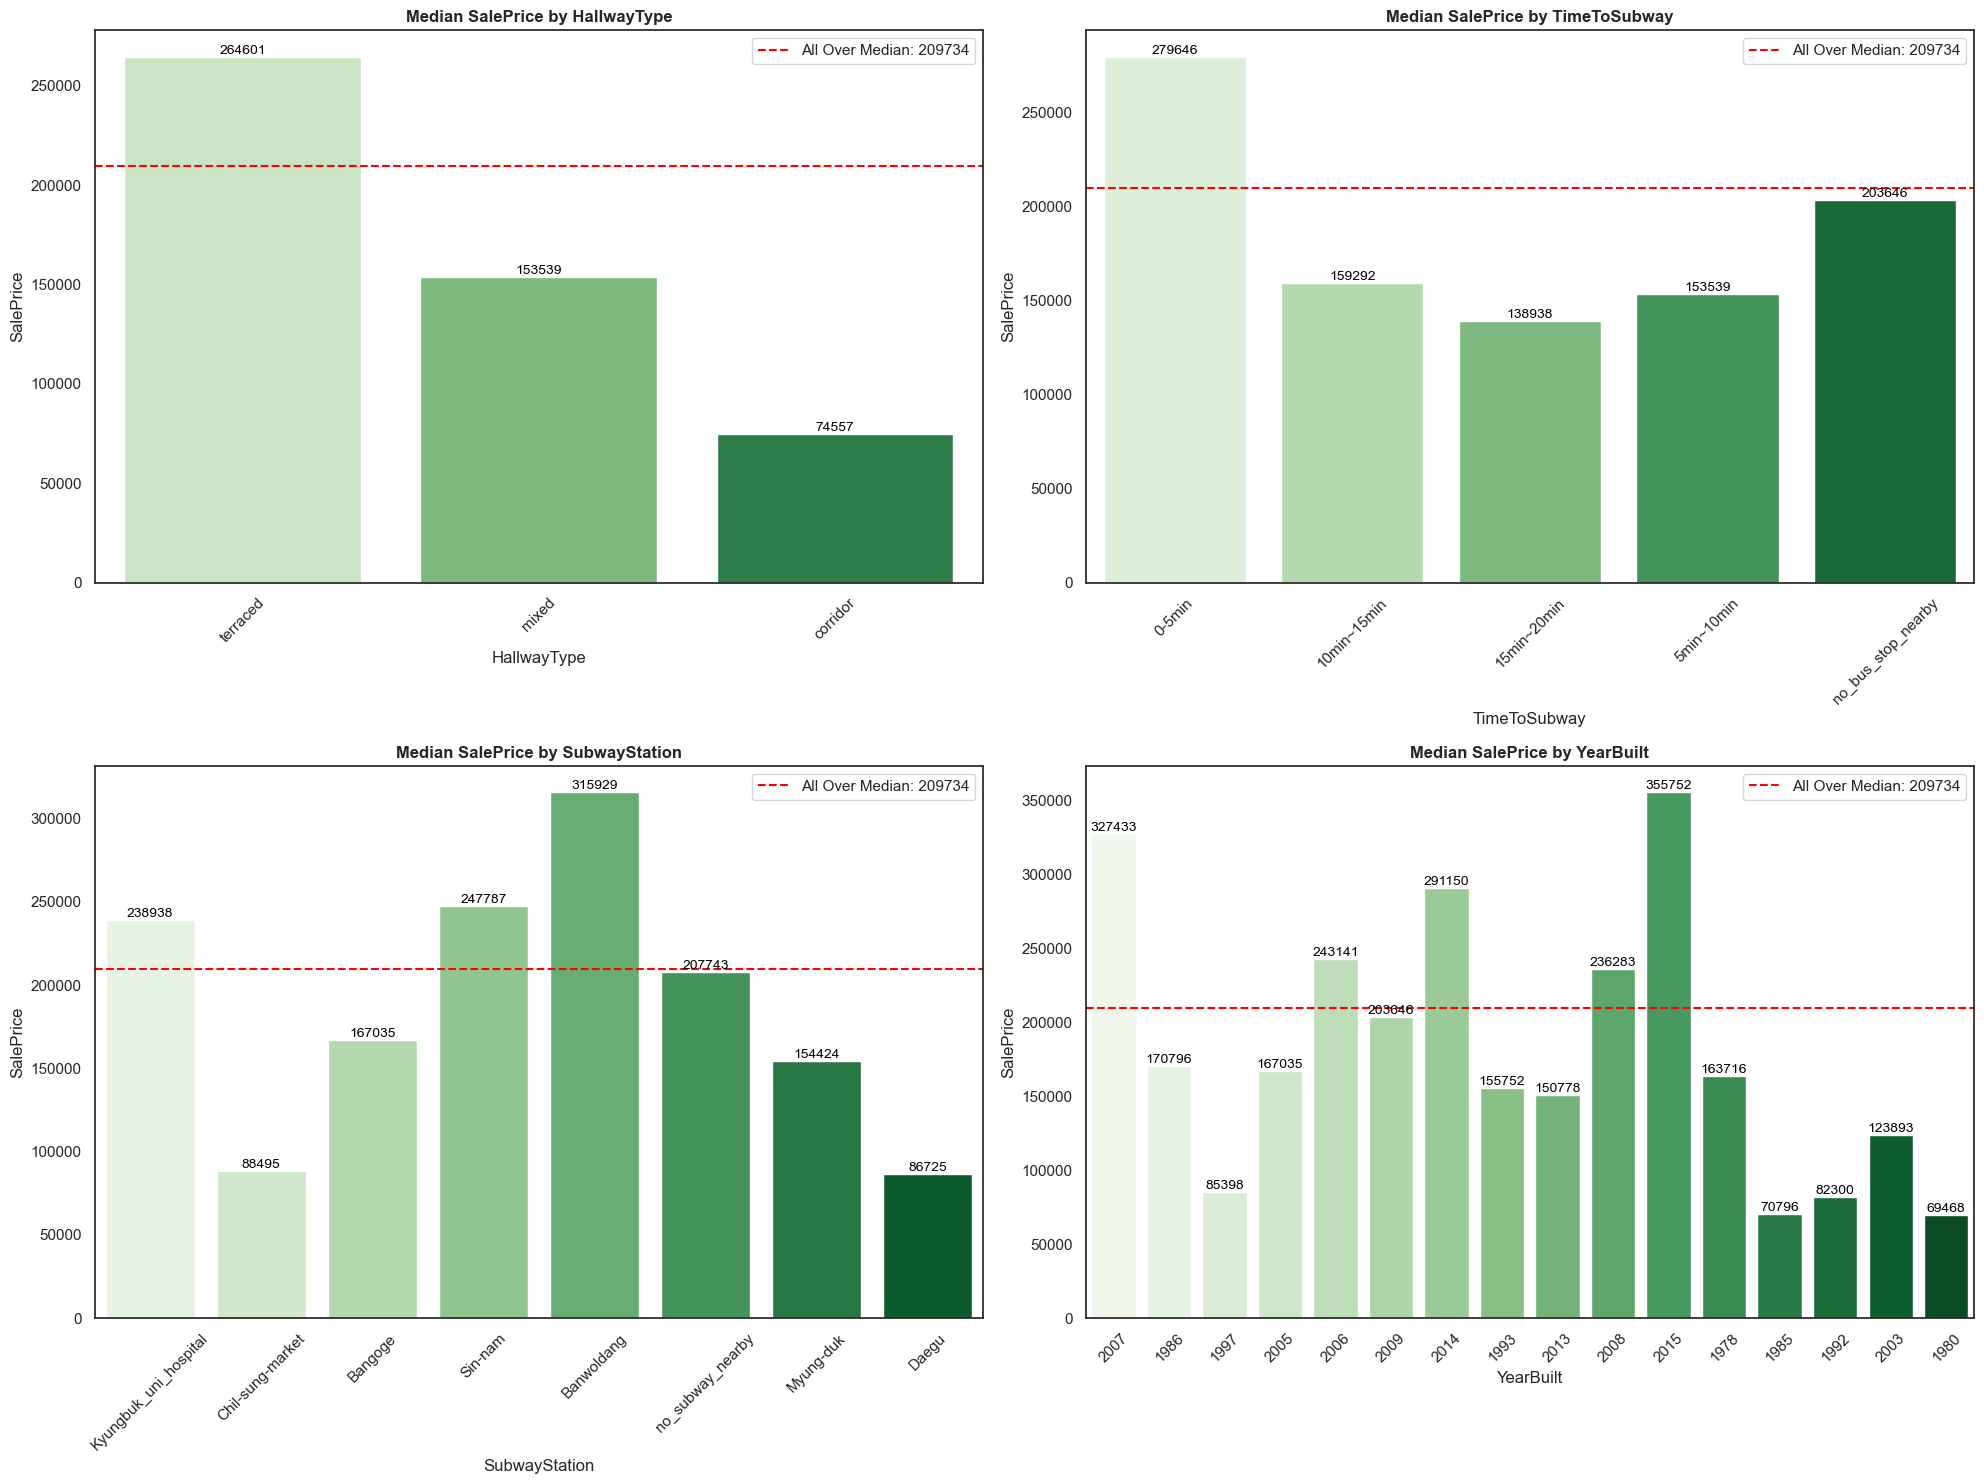

In [25]:
target_variable = 'SalePrice'


fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, cat_var in enumerate(cat):

    overall_median = df_prep['SalePrice'].median()

    ax = sns.barplot(x=cat_var, y='SalePrice', data=df, estimator= np.median, ci=None, ax=axes[i], palette="Greens")
    ax.set_title(f'Median SalePrice by {cat_var}', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

    median_line = ax.axhline(overall_median, color='red', linestyle='--', label=f'All Over Median: {overall_median:.0f}')
    ax.legend(handles=[median_line], loc='upper right')

    for p in ax.patches:
        height = p.get_height()  
        ax.annotate(f'{height:.0f}',  
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom',  
                    fontsize=10, color='black') 
   

plt.tight_layout()
plt.show()


**The red dashed line represents the overall median sale price across all properties. Categories that have bars above this line are generally associated with higher-value properties, while those below indicate lower-value properties.**

**HallwayType and SalePrice** <br>
Properties with "terraced" hallway types have the highest median sale prices, significantly above the overall median, while those with "corridor" types have much lower prices. This suggests that buyers likely perceive "terraced" hallway types as more desirable, possibly due to their design, privacy, or associated living quality.

**TimeToSubway and SalePrice** <br>
Proximity to the subway is generally associated with higher property values. Properties closest to the subway (0-5 minutes) command the highest prices, reflecting the premium placed on easy access to public transportation. However, properties with "no nearby subway" still hold their value better than those that are 10-20 minutes away, suggesting that the presence of other amenities might mitigate the lack of subway proximity.

**SubwayStation and SalePrice** <br>
Different subway stations are associated with varying property values. Properties near "Banwoldang" station have the highest median sale prices, while those near "Daegu" station have the lowest. This likely reflects differences in the desirability of neighborhoods, available amenities, and accessibility associated with each station.

**YearBuilt and SalePrice** <br>
Properties built in more recent years (particularly from 2003 to 2015) generally have higher median sale prices, while those built in earlier years, especially before 1980, tend to have lower median prices. This reflects buyer preferences for newer properties that are likely to have modern amenities, better construction quality, and lower maintenance costs.

## Market Price Competitiveness

In [26]:
average_price_by_type = df_prep.groupby('HallwayType')['SalePrice'].mean().reset_index()
average_price_by_type.rename(columns={'SalePrice': 'AverageMarketPrice'}, inplace=True)
average_price_by_type

,HallwayType,AverageMarketPrice
0,corridor,87968.137931
1,mixed,155799.391689
2,terraced,275839.729035


In [27]:
df_prep = df_prep.merge(average_price_by_type, on='HallwayType', how='left')
df_prep['MarketPriceCompetitivenessScore'] = df_prep['SalePrice'] / df_prep['AverageMarketPrice']

def interpret_score(score):
        if score == 1:
            return 'Priced at Market Avg'
        elif score > 1:
            return 'Priced Above Market Avg'
        else:
            return 'Priced Below Market Avg'

df_prep['ScoreInterpretation'] = df_prep['MarketPriceCompetitivenessScore'].apply(interpret_score)
df_prep.head(5)

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice,AverageMarketPrice,MarketPriceCompetitivenessScore,ScoreInterpretation
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,2007,10,1387,346017,275839.729035,1.254413,Priced Above Market Avg
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,1986,4,914,150442,275839.729035,0.545396,Priced Below Market Avg
2,mixed,15min~20min,Chil-sung-market,1.0,1997,5,558,61946,155799.391689,0.397601,Priced Below Market Avg
3,mixed,5min~10min,Bangoge,5.0,2005,7,914,165486,155799.391689,1.062174,Priced Above Market Avg
4,terraced,0-5min,Sin-nam,0.0,2006,5,1743,311504,275839.729035,1.129293,Priced Above Market Avg


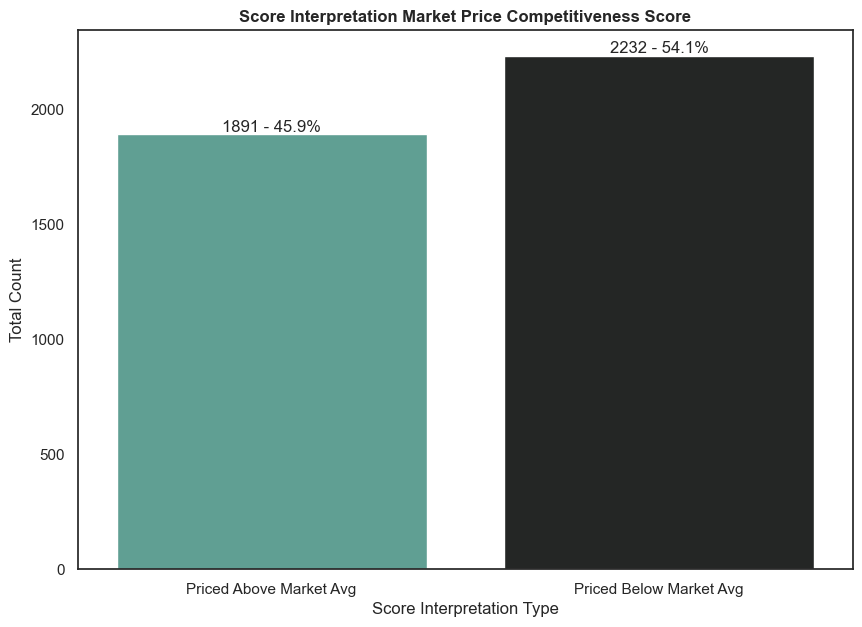

In [28]:
plt.figure(figsize=(10, 7))

total_count = df_prep['ScoreInterpretation'].value_counts().sum()

ax = sns.countplot(x='ScoreInterpretation', data=df_prep,  palette= 'dark:#5A9_r')
plt.title('Score Interpretation Market Price Competitiveness Score', fontweight='bold')
plt.xlabel('Score Interpretation Type')
plt.ylabel('Total Count')

for patch in ax.patches:
    height = patch.get_height()
    percentage = f'{(height / total_count) * 100:.1f}%'
    ax.text(patch.get_x() + patch.get_width() / 2, height, 
            f'{int(height)} - {percentage}', 
            ha='center', va='bottom')



    54.1% of the properties are priced below the market average, while 45.9% are priced above the market average. This indicates that the majority of the apartments are positioned to be more competitive in pricing.

    The distribution is fairly balanced, with a slight tilt toward more properties being priced below the market average. This suggests a strategy aimed at attracting a broader range of potential buyers, particularly those who are price-sensitive or looking for deals below the average market price.

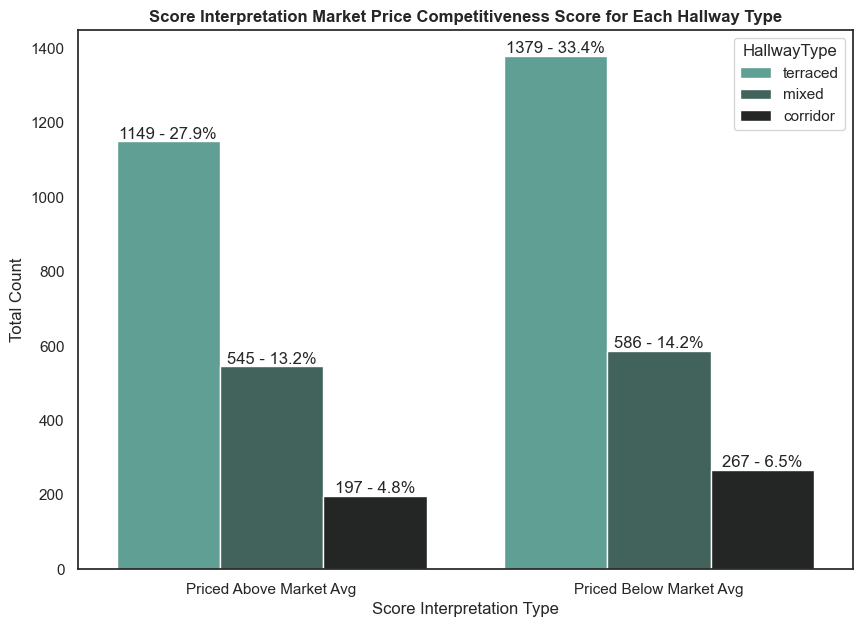

In [68]:
plt.figure(figsize=(10, 7))

total_count = df_prep['ScoreInterpretation'].value_counts().sum()

ax = sns.countplot(x='ScoreInterpretation', data=df_prep,  hue='HallwayType', palette= 'dark:#5A9_r')
plt.title('Score Interpretation Market Price Competitiveness Score for Each Hallway Type', fontweight='bold')
plt.xlabel('Score Interpretation Type')
plt.ylabel('Total Count')

for patch in ax.patches:
    height = patch.get_height()
    percentage = f'{(height / total_count) * 100:.1f}%'
    ax.text(patch.get_x() + patch.get_width() / 2, height, 
            f'{int(height)} - {percentage}', 
            ha='center', va='bottom')



**Terraced Hallway Type** <br>
Highest Count Across All Categories: The terraced hallway type dominates in both pricing categories — with 27.9% of properties priced above the market average and 33.4% priced below the market average. There are more terraced properties priced below the market average (1,379 properties) compared to those priced above (1,149 properties). This suggests that a significant portion of terraced properties are positioned as budget-friendly options.

**Mixed Hallway Type** <br>
Even Distribution Across Price Categories: The mixed hallway type shows a relatively balanced distribution between properties priced above the market average (13.2% or 545 properties) and those priced below (14.2% or 586 properties). This balanced representation suggests a flexible strategy for mixed hallway types, targeting both premium and budget market segments with nearly equal focus.

**Corridor Hallway Type** <br>
Least Common Hallway Type Across All Categories: The corridor hallway type has the lowest representation in both categories, with 4.8% (197 properties) priced above the market average and 6.5% (267 properties) priced below the market average. More corridor-type properties are priced below the market average, suggesting they are generally positioned as more affordable options.

## Price per Facility Metric

The Price per Facility metric is designed to evaluate how much an apartment's sale price correlates with the number of facilities available both within the apartment complex itself and in its immediate vicinity. 

In [30]:
df_prep['TotalFacilities'] = df_prep['N_FacilitiesNearBy(ETC)'] + df_prep['N_FacilitiesInApt']
df_prep['PricePerFacility'] = df_prep['SalePrice'] / df_prep['TotalFacilities']

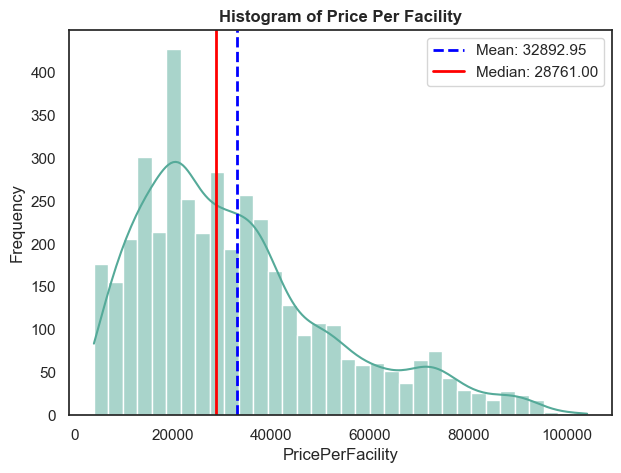

In [31]:
plt.figure(figsize=(7, 5))

ax = sns.histplot(df_prep['PricePerFacility'], kde=True)
plt.title(f'Histogram of Price Per Facility', fontweight='bold')
plt.xlabel('PricePerFacility')
plt.ylabel('Frequency')

add_mean_median_annotations(ax, df_prep['PricePerFacility'])

plt.show()

The distribution of the Price Per Facility is right-skewed, indicating that most apartments have a lower price per facility, with fewer apartments having a higher price per facility. The majority of properties have a Price Per Facility between 10,000 and 40,000, with a noticeable concentration around 20,000 to 30,000. This suggests that many apartments are positioned to provide relatively affordable access to facilities.

There are apartments with a Price Per Facility exceeding 60,000, extending up to about 100,000. These could represent premium properties with fewer facilities or properties priced higher than the market norm.
These outliers suggest that a few apartments are priced significantly higher per facility, potentially targeting a niche market segment or reflecting unique, high-demand characteristics (like location or luxury features).

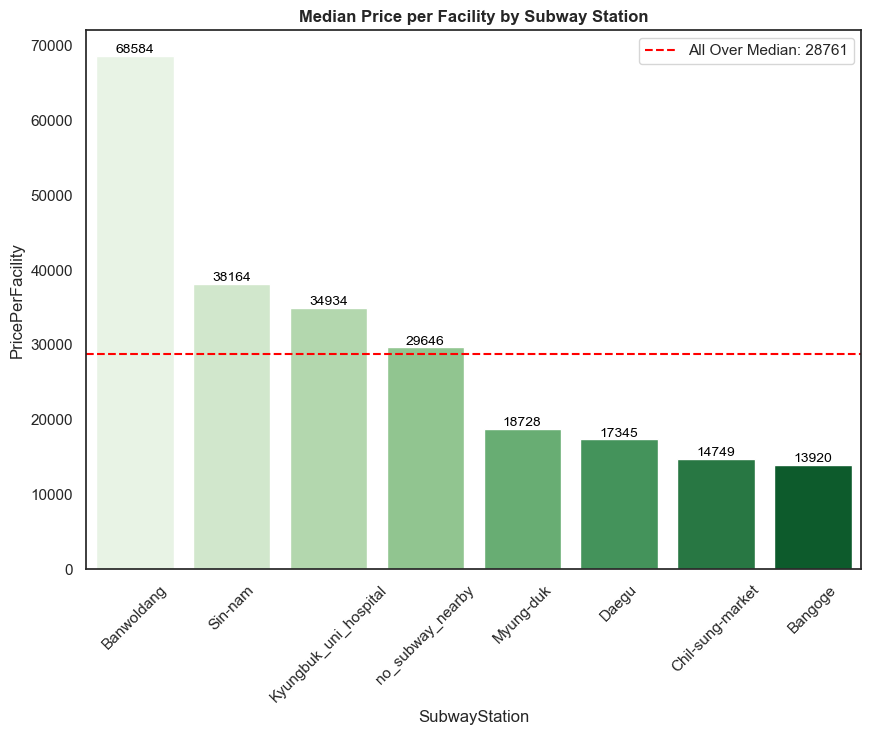

In [32]:
overall_median = df_prep['PricePerFacility'].median()
median_order = df_prep.groupby('SubwayStation')['PricePerFacility'].median().sort_values(ascending=False).index

plt.figure(figsize=(10, 7)) 

ax = sns.barplot(x='SubwayStation', y='PricePerFacility', data=df_prep, estimator= np.median, ci=None, palette='Greens', order=median_order)
                 
ax.set_title(f'Median Price per Facility by Subway Station', fontweight='bold')
ax.tick_params(axis='x', rotation=45)

median_line = ax.axhline(overall_median, color='red', linestyle='--', label=f'All Over Median: {overall_median:.0f}')
ax.legend(handles=[median_line], loc='upper right')

for p in ax.patches:
    height = p.get_height()  
    ax.annotate(f'{height:.0f}',  
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom',  
                fontsize=10, color='black') 

Banwoldang has the highest median price per facility, significantly above all other stations at 68,584. This indicates that properties around this subway station command a premium price, likely due to high demand, exclusive location, or limited availability of facilities.

Stations like Myung-duk (18,728), Daegu (17,345), Chil-sung-market (14,749), and Bangoge (13,920) have a median price per facility significantly below the overall median. This suggests these areas may be more affordable, potentially due to less demand, more availability of facilities, or a less desirable location.

Properties with "no subway nearby" still have a median price per facility of 29,646, slightly above the overall median. This suggests that, despite the lack of direct subway access, these properties maintain a relatively competitive price. This could be due to other compensatory amenities or advantages such as access to other transportation means, quieter residential environments, or other desirable features.

The wide range of median prices per facility (from 68,584 to 13,920) suggests a strong market segmentation based on location. Some subway stations are clearly positioned as premium locations, while others cater to more budget-conscious buyers.

# Modeling & Evaluation

## Model Benchmark 1
Establishing a benchmark model by employing multiple algorithms and utilizing GridSearchCV for model optimization and selection.


In [33]:
linreg = LinearRegression()
lasso = Lasso()
ridge = Ridge()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
svr = SVR()

In [34]:
estimator = Pipeline([
    ('prep', transformer),
    ('reg',linreg) # linreg default model
])

hyperparam_space = {
    'reg': [lasso, ridge, knn, dt, rf, gb, xgb, svr]
}

crossval = KFold(n_splits=5, shuffle=True, random_state=42)

grid_model = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv = crossval,
    scoring=['neg_mean_absolute_error','neg_mean_absolute_percentage_error','neg_mean_squared_log_error'],
    refit= 'neg_mean_squared_log_error', 
    n_jobs=-1, 
)

#  dalam kasus ini metrik yang digunakan pada parameter refit adalah MSLE karena variabel target memiliki ragam yang besar

In [35]:
grid_model.fit(X_trainval, y_trainval)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['HallwayType',
                                                                          'SubwayStation']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
1...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...),
                                 SVR()]},
             refit='neg_mean_squared_log_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_mean_squared_log_error'])

In [36]:
hasil_grid = pd.DataFrame(grid_model.cv_results_)

display(hasil_grid[['param_reg',
                    'mean_test_neg_mean_absolute_error','std_test_neg_mean_absolute_error','rank_test_neg_mean_absolute_error',
                    'mean_test_neg_mean_absolute_percentage_error','std_test_neg_mean_absolute_percentage_error','rank_test_neg_mean_absolute_percentage_error',
                    'mean_test_neg_mean_squared_log_error','std_test_neg_mean_squared_log_error','rank_test_neg_mean_squared_log_error']],
        grid_model.best_params_, 
        grid_model.best_score_)

,param_reg,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error
0,Lasso(),-42491.620117,498.359267,6,-0.232093,0.004257,6,-0.074029,0.004351,7
1,Ridge(),-42494.216839,499.780130,7,-0.232104,0.004241,7,-0.073981,0.004318,6
2,KNeighborsRegressor(),-36973.435267,891.727942,5,-0.199082,0.009952,5,-0.061042,0.002240,5
3,DecisionTreeRegressor(random_state=42),-34706.236181,379.812708,3,-0.185592,0.004528,3,-0.051695,0.002687,4
4,RandomForestRegressor(random_state=42),-34632.907422,338.290581,1,-0.185253,0.004046,2,-0.051452,0.001620,3
5,GradientBoostingRegressor(random_state=42),-34972.212296,504.115419,4,-0.187992,0.004953,4,-0.050827,0.001371,1
6,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=42, ...)",-34637.970216,327.570959,2,-0.184909,0.004022,1,-0.051223,0.001715,2
7,SVR(),-87423.693388,1175.783933,8,-0.579194,0.020711,8,-0.320194,0.011618,8


{'reg': GradientBoostingRegressor(random_state=42)}

-0.05082663270795349

Based on the results above, the best parameters according to MSLE are achieved by the GradientBoostingRegressor in the 1st rank, followed by the XGBRegressor in the 2nd rank. Therefore, these two algorithms can be compared as follows:

- As shown in the results above, the GradientBoostingRegressor ranks 1st based on MSLE. It also holds the 4th rank in terms of MAE and MAPE metrics.
- The XGBRegressor ranks 2nd based on both MAE and MSLE, and secures the 1st rank based on the MAPE metric.

## Model Benchmark 2 - Transforming the Target Variable
Establishing a benchmark model by applying multiple algorithms using GridSearchCV, but with the target variable undergoing a transformation process using TransformedTargetRegressor(). According to the [scikit learn](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py) documentation, transforming the target variable can adjust its distribution closer to normal and potentially enhance model performance. A non-normal distribution of the target variable can adversely affect model performance, while transforming the target variable may reduce regression metric values, thereby improving model performance. Additionally, target transformation impacts each algorithm differently [(Dimas, 2021).](https://medium.com/analytics-vidhya/effect-of-target-transformation-on-abalone-age-prediction-using-regression-model-da6d3a185a31)

In [37]:
log_lr = TransformedTargetRegressor(linreg, func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(lasso, func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(ridge, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_gb = TransformedTargetRegressor(gb, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_svr = TransformedTargetRegressor(svr, func=np.log, inverse_func=np.exp)

In [38]:
estimator = Pipeline([
    ('prep', transformer),
    ('reg',log_lr) 
])

hyperparam_space = {
    'reg': [log_lasso,log_ridge,log_knn,log_dt,log_rf,log_gb,log_xgb,log_svr]
}

crossval = KFold(n_splits=5, shuffle=True, random_state=42)

grid_model_log = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv = crossval,
    scoring=['neg_mean_absolute_error','neg_mean_absolute_percentage_error','neg_mean_squared_log_error'],
    refit= 'neg_mean_squared_log_error',
    n_jobs=-1, 
)

In [39]:
grid_model_log.fit(X_trainval,y_trainval)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['HallwayType',
                                                                          'SubwayStation']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
1...
                                                                                   missing=nan,
                                                                                   monotone_constraints=None,
                                                                                   n_estimators=100,
                                                                                   n_jobs=None,
                                                                                   num_parallel_tree=None,
                                                                                   predictor=None,
                                                                                   random_state=42, ...)),
                                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                                            inverse_func=<ufunc 'exp'>,
                                                            regressor=SVR())]},
             refit='neg_mean_squared_log_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_mean_squared_log_error'])

In [40]:
hasil_grid_log = pd.DataFrame(grid_model_log.cv_results_)

display(hasil_grid_log[['param_reg',
                    'mean_test_neg_mean_absolute_error','std_test_neg_mean_absolute_error','rank_test_neg_mean_absolute_error',
                    'mean_test_neg_mean_absolute_percentage_error','std_test_neg_mean_absolute_percentage_error','rank_test_neg_mean_absolute_percentage_error',
                    'mean_test_neg_mean_squared_log_error','std_test_neg_mean_squared_log_error','rank_test_neg_mean_squared_log_error']],
        grid_model_log.best_params_, 
        grid_model_log.best_score_)

,param_reg,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error
0,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=Lasso())",-65365.193369,2273.963971,8,-0.346836,0.009886,8,-0.162983,0.006375,8
1,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=Ridge())",-43186.127965,1327.796484,6,-0.226368,0.005749,6,-0.074837,0.004317,6
2,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=KNeighborsRegressor())",-36523.501559,887.952930,5,-0.191414,0.008384,5,-0.059589,0.002544,5
3,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=DecisionTreeRegressor(random_state=42))",-33992.052186,251.265550,3,-0.174785,0.003902,2,-0.049287,0.001587,3
4,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=RandomForestRegressor(random_state=42))",-33987.096954,226.949662,2,-0.175046,0.003633,3,-0.049442,0.001346,4
5,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=GradientBoostingRegressor(random_state=42))",-34116.943160,394.289947,4,-0.175539,0.004554,4,-0.048897,0.002018,1
6,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=XGBRegressor(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None,\n early_stopping_rounds=None,\n enable_categorical=False,\n eval_metric=None,\n feature_types=None,\n gamma=None, gpu_id=None,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=None,\n max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None,\n max_depth=None,\n max_leaves=None,\n min_child_weight=None,\n missing=nan,\n monotone_constraints=None,\n n_estimators=100, n_jobs=None,\n num_parallel_tree=None,\n predictor=None,\n random_state=42, ...))",-33921.051018,325.801615,1,-0.174206,0.004537,1,-0.048995,0.001901,2
7,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=SVR())",-52540.902561,1233.405201,7,-0.274704,0.007359,7,-0.102556,0.003006,7


{'reg': TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                            regressor=GradientBoostingRegressor(random_state=42))}

-0.048896878496947196

Based on the results above, the best parameters according to MSLE remain the GradientBoostingRegressor in 1st place and the XGBRegressor in 2nd place, similar to the findings before using the TransformedTargetRegressor. The comparison between the GradientBoostingRegressor and XGBRegressor algorithms is as follows:

- As shown above, the GradientBoostingRegressor is the top model based on the MSLE metric. However, it only outperforms in terms of MSLE, while it ranks 4th in both the MAE and MAPE metrics.
- The XGBRegressor holds the 2nd position in terms of MSLE but ranks 1st based on both the MAE and MAPE metrics.


## Comparing Model Benchmark 1 & 2

In [41]:
banding_model_benchmark = hasil_grid_log[(hasil_grid_log['rank_test_neg_mean_squared_log_error'] == 1) | (hasil_grid_log['rank_test_neg_mean_squared_log_error'] == 2)] 
banding_model_benchmark = banding_model_benchmark.append(hasil_grid[(hasil_grid['rank_test_neg_mean_squared_log_error'] == 1) | (hasil_grid['rank_test_neg_mean_squared_log_error'] == 2)]) 
banding_model_benchmark = banding_model_benchmark[['mean_test_neg_mean_absolute_error','std_test_neg_mean_absolute_error',
                    'mean_test_neg_mean_absolute_percentage_error','std_test_neg_mean_absolute_percentage_error',
                    'mean_test_neg_mean_squared_log_error','std_test_neg_mean_squared_log_error']]
banding_model_benchmark.insert(loc=0, column='Model', value=['GB with TTR','XGB with TTR','GB','XGB'])
banding_model_benchmark.reset_index(drop='first', inplace = True)
banding_model_benchmark

,Model,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error
0,GB with TTR,-34116.943160,394.289947,-0.175539,0.004554,-0.048897,0.002018
1,XGB with TTR,-33921.051018,325.801615,-0.174206,0.004537,-0.048995,0.001901
2,GB,-34972.212296,504.115419,-0.187992,0.004953,-0.050827,0.001371
3,XGB,-34637.970216,327.570959,-0.184909,0.004022,-0.051223,0.001715


Based on the comparison table above, models that transform the target variable generally have a lower MSLE value compared to models that do not transform the target variable. Therefore, the models to be compared are GB with TTR and XGB with TTR.

## Prediction Using Test Data 1
- XGBRegressor with Transformed Target Regressor (TTR)

In [42]:
xgb = XGBRegressor(random_state=42)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)

model_log_xgb = Pipeline([
    ('preprocessing', transformer),
    ('model', log_xgb)
    ])

model_log_xgb.fit(X_trainval, y_trainval)
y_pred = model_log_xgb.predict(X_test)

hasil_pred = pd.DataFrame()
hasil_pred['Model'] = ['XGB with TTR']
hasil_pred['MAE'] = [mean_absolute_error(y_test, y_pred)]
hasil_pred['MAPE'] = [mean_absolute_percentage_error(y_test, y_pred)]
hasil_pred['MSLE'] = [mean_squared_log_error(y_test, y_pred)]

display(hasil_pred, y_pred)


,Model,MAE,MAPE,MSLE
0,XGB with TTR,31603.71679,0.168463,0.04655


array([291988.25 , 168060.1  ,  77657.33 , 409529.72 , 194332.56 ,
       194332.56 , 149034.06 , 211694.48 ,  74431.69 , 222028.95 ,
       374934.62 , 100693.58 , 289293.56 , 213863.69 , 176612.89 ,
       251331.58 , 100693.58 , 237677.   , 210842.42 , 388730.16 ,
        52794.57 , 156535.72 , 149034.06 , 222028.95 ,  76003.88 ,
       203896.64 , 300007.2  , 269648.16 , 345121.47 , 329644.3  ,
       233994.81 , 149034.06 , 100487.625, 269648.16 , 345121.47 ,
        78815.44 , 285531.1  ,  81918.055, 251331.58 ,  94321.625,
       261384.11 , 149034.06 , 213863.69 , 328892.88 ,  84352.375,
       154736.67 , 100693.58 , 157226.64 , 223188.1  , 276991.75 ,
       156535.72 , 232221.03 , 281636.44 , 116041.82 , 100487.625,
       239743.36 , 261384.11 , 345121.47 , 457991.53 , 223188.1  ,
       194332.56 , 291988.25 , 261384.11 , 261384.11 , 203896.64 ,
       156535.72 , 116041.82 , 210842.42 , 288710.9  , 407643.78 ,
       168060.1  , 203896.64 , 176612.89 , 156535.72 , 334828.

## Hyperparameter tuning XGBRegressor

- Max depth: Defines the maximum depth of the tree.
- N estimators: Specifies the number of trees to be created.
- Subsample: Determines the ratio of the training data used to build each tree.
- Gamma: Controls the minimum loss reduction required to make a further partition on a leaf node.
- Learning rate: Determines how quickly the model adapts or "learns" from the data.
- Random state: Ensures consistent and reproducible results.

In [43]:
xgb = XGBRegressor(random_state=42)

estimator = Pipeline([
    ('prep', transformer),
    ('model',xgb) 
])

hyperparam_space = {
    'model__max_depth': [4,5,6,7,8], # default 6
    'model__n_estimators': [100,200], # default 100
    'model__subsample': [0.5,1], # default 1, 0.5 untuk mencegah overfitting
    'model__gamma': [0,2,4,6], # default 0
    'model__learning_rate': [0.3,0.5], # default 0.3
    'model__random_state': [42]
}

crossval = KFold(n_splits=5, shuffle=True, random_state=42)

grid_model_tuning = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv = crossval,
    scoring=['neg_mean_absolute_error','neg_mean_absolute_percentage_error','neg_mean_squared_log_error'],
    refit= 'neg_mean_squared_log_error',
    n_jobs=-1, 
)

In [44]:
grid_model_tuning.fit(X_trainval, y_trainval)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['HallwayType',
                                                                          'SubwayStation']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
1...
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0, 2, 4, 6],
                         'model__learning_rate': [0.3, 0.5],
                         'model__max_depth': [4, 5, 6, 7, 8],
                         'model__n_estimators': [100, 200],
                         'model__random_state': [42],
                         'model__subsample': [0.5, 1]},
             refit='neg_mean_squared_log_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_mean_squared_log_error'])

In [45]:
hasil_grid_tuning = pd.DataFrame(grid_model_tuning.cv_results_)

display(grid_model_tuning.best_params_, 
        grid_model_tuning.best_score_)

{'model__gamma': 0,
 'model__learning_rate': 0.3,
 'model__max_depth': 4,
 'model__n_estimators': 100,
 'model__random_state': 42,
 'model__subsample': 0.5}

-0.05040247722878864

## Prediction Using Test Data 2
- XGBRegressor Tunning with Transformed Target Regressor (TTR)

In [46]:
grid_model_tuning.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['HallwayType',
                                                   'SubwayStation']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
15min~20min           3
dtype: int64},
                                                                          {'col': 'YearBuilt',
                                                                           'data_type': dtype('O'),
                                                                           'mappin...
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [47]:
model_log_xgb_tuning = TransformedTargetRegressor(grid_model_tuning.best_estimator_,func=np.log, inverse_func=np.exp)

model_log_xgb_tuning.fit(X_trainval, y_trainval)
y_pred_tuning = model_log_xgb_tuning.predict(X_test)

hasil_pred_tuning = pd.DataFrame()
hasil_pred_tuning['Model'] = ['XGB  Tuning with TTR']
hasil_pred_tuning['MAE'] = [mean_absolute_error(y_test, y_pred_tuning)]
hasil_pred_tuning['MAPE'] = [mean_absolute_percentage_error(y_test, y_pred_tuning)]
hasil_pred_tuning['MSLE'] = [mean_squared_log_error(y_test, y_pred_tuning)]

display(hasil_pred_tuning, y_pred_tuning)

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR,31572.332027,0.167993,0.046331


array([292828.75 , 168524.23 ,  78025.09 , 404965.12 , 190106.03 ,
       190106.03 , 149969.62 , 206087.34 ,  74746.31 , 225188.84 ,
       372064.4  , 100150.66 , 288457.72 , 213774.78 , 175524.33 ,
       250727.1  , 100150.66 , 233393.98 , 212826.88 , 390869.9  ,
        52500.85 , 156662.22 , 149969.62 , 225188.84 ,  77466.87 ,
       202646.28 , 309659.2  , 271928.2  , 350188.47 , 326071.5  ,
       231541.69 , 149969.62 , 100238.28 , 271928.2  , 350188.47 ,
        78855.51 , 277935.62 ,  83918.05 , 250727.1  ,  94974.055,
       263874.44 , 149969.62 , 213774.78 , 339337.56 ,  81867.75 ,
       149001.5  , 100150.66 , 158983.52 , 222369.06 , 278197.1  ,
       156662.22 , 228067.22 , 277918.4  , 114177.625, 100238.28 ,
       240376.62 , 263874.44 , 350188.47 , 457261.4  , 222369.06 ,
       190106.03 , 292828.75 , 263874.44 , 263874.44 , 202646.28 ,
       156662.22 , 114177.625, 212826.88 , 291568.94 , 402914.56 ,
       168524.23 , 202646.28 , 175524.33 , 156662.22 , 324186.

## Comparing Before and After TUnning

In [48]:
hasil_akhir = hasil_pred_tuning.copy()
hasil_akhir = hasil_akhir.append(hasil_pred.iloc[0,:])
hasil_akhir.reset_index(drop='first', inplace = True)
hasil_akhir

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR,31572.332027,0.167993,0.046331
1,XGB with TTR,31603.716790,0.168463,0.046550


Based on the results of the model comparison using the test data, XGB Tuning with TTR shows a slight improvement in metric values compared to the model before tuning. Therefore, **the chosen model is XGB Tuning with TTR**.

## Final Result

In [49]:
resid = pd.DataFrame()
resid['y_aktual'] = y_test
resid['y_prediksi'] = np.round(y_pred_tuning)
resid['residual'] = np.round(y_test - y_pred_tuning)
resid.reset_index(drop='first', inplace = True)
resid.head(3)

,y_aktual,y_prediksi,residual
0,255442,292829.0,-37387.0
1,184955,168524.0,16431.0
2,70796,78025.0,-7229.0


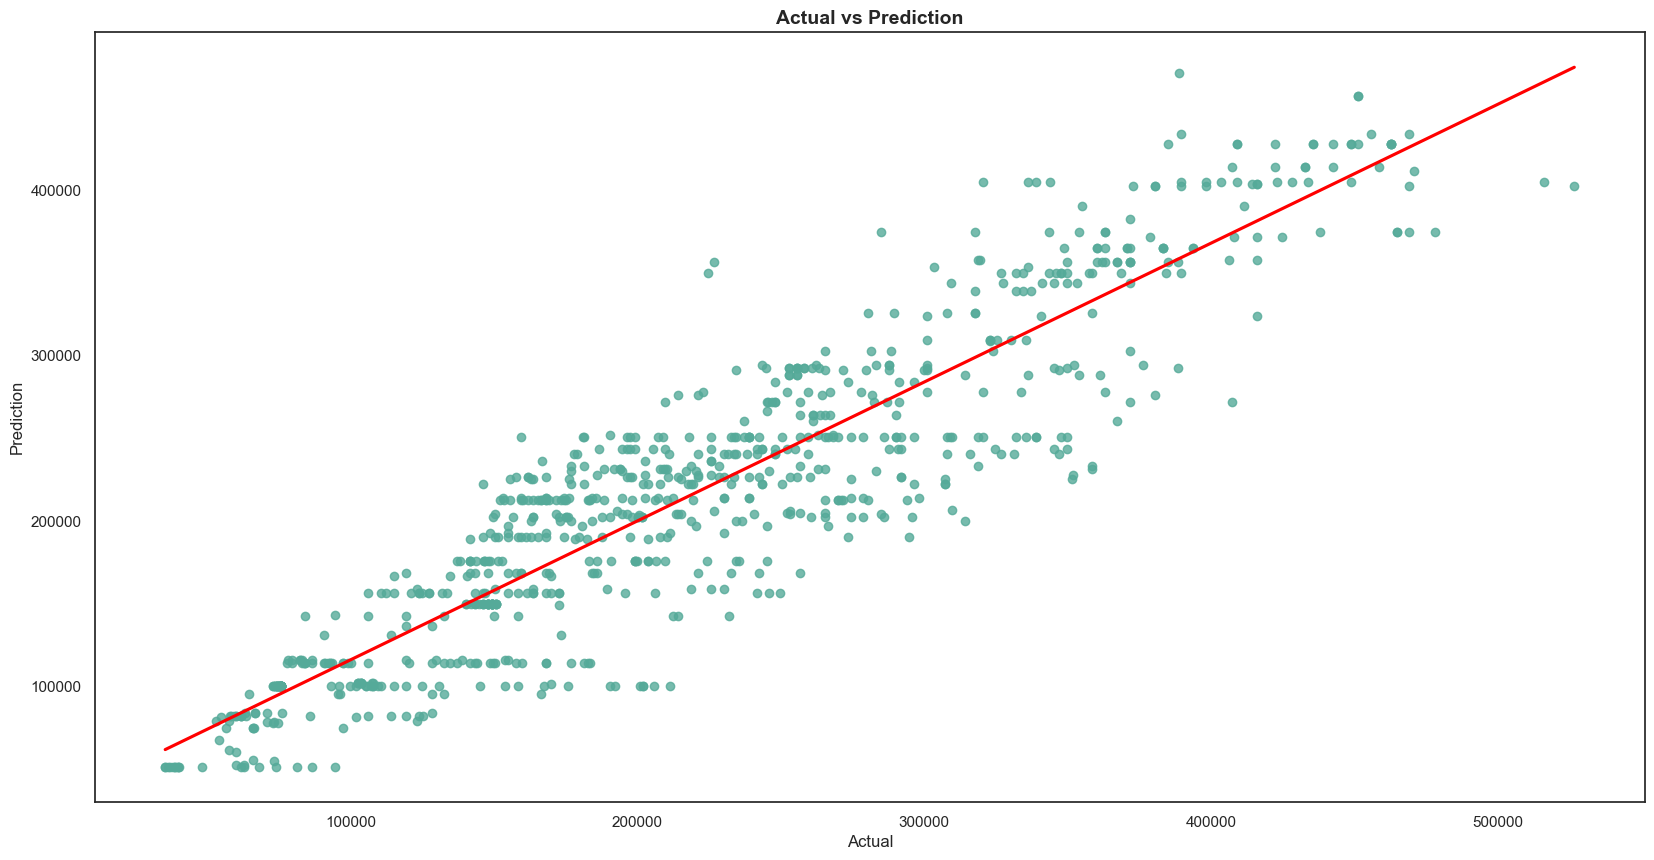

In [69]:
plt.figure(figsize=(20,10))
sns.regplot(x='y_aktual',
            y='y_prediksi', 
            data=resid,
            ci = None,
            line_kws={'color': 'r'})
plt.title('Actual vs Prediction', fontweight = 'bold', fontsize = 14)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

In [51]:
rekap_resid = check_outliers(resid, resid.columns)[0]

display(hasil_pred_tuning,
        rekap_resid)

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR,31572.332027,0.167993,0.046331


,Column,Q1,Q3,IQR,Upper Bound,Lower Bound,Number of Outliers,Proportion of Outliers
2,residual,-25063.0,23591.0,48654.0,96572.0,-98044.0,26,3.15
1,y_prediksi,149970.0,271928.0,121958.0,454865.0,-32967.0,3,0.36
0,y_aktual,146902.0,287610.0,140708.0,498672.0,-64160.0,2,0.24


From the scatter plot visualization of predicted versus actual values, it is evident that some bias still exists. One example is for apartment prices above 500 thousand, where the model predicts prices below 500 thousand, even though the actual prices are above 500 thousand. Despite the presence of some bias, the data distribution shows a fairly clear regression pattern.

Based on the regression evaluation metrics, the model can predict apartment prices with an error of approximately ±31,572 won (MAE) or an error of ±16.7% (MAPE) from the actual price. A MAPE value between 10% and 20% is generally considered indicative of a good model (Stephen, 2022)

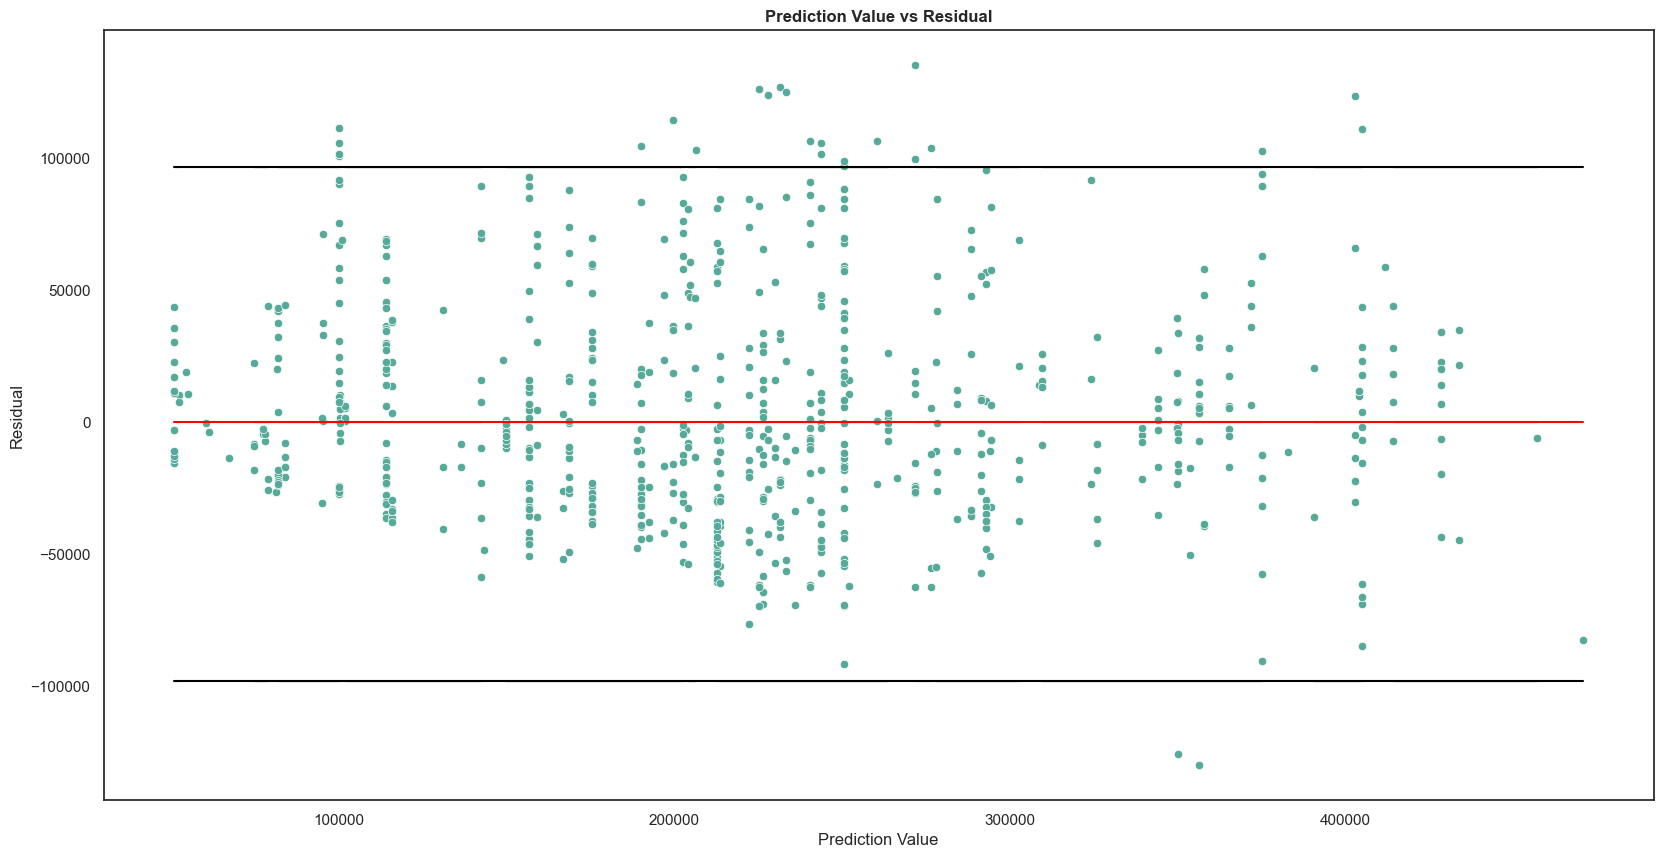

In [52]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='y_prediksi', y='residual', data=resid)
sns.lineplot(x='y_prediksi', y=0, data=resid, color='red')
sns.lineplot(x='y_prediksi', y=96572.0, data=resid, color='black') # batas atas residual
sns.lineplot(x='y_prediksi', y=-98044.0, data=resid, color='black') # batas bawah residual
plt.title('Prediction Value vs Residual', fontweight = 'bold')
plt.xlabel('Prediction Value')
plt.ylabel('Residual')
plt.show()

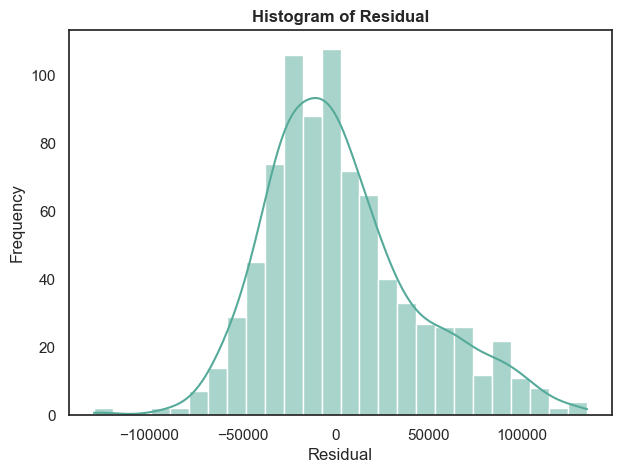

In [53]:
plt.figure(figsize=(7, 5))

ax = sns.histplot(resid['residual'], kde=True)
plt.title(f'Histogram of Residual', fontweight='bold')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.show()

From the visualization of predicted values and residuals, the following observations can be made:

- A large number of data points are clustered around 0, although some outliers remain in the residuals (indicating bias).
- The errors do not show any correlation, as there is no discernible pattern in the scatter plot.
- According to the residual histogram, the data distribution is approximately normal.

## Feature Importance

In [54]:
model_log_xgb_tuning

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('ohe',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['HallwayType',
                                                                                        'SubwayStation']),
                                                                                      ('ordinal',
                                                                                       OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                                                                'data_type': dtype('O'),
                                                                                                                'mapping': no_bus_stop_nearby    0
0-5min                1
10min...
                                                                   gpu_id=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.3,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=4,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=42, ...))]))

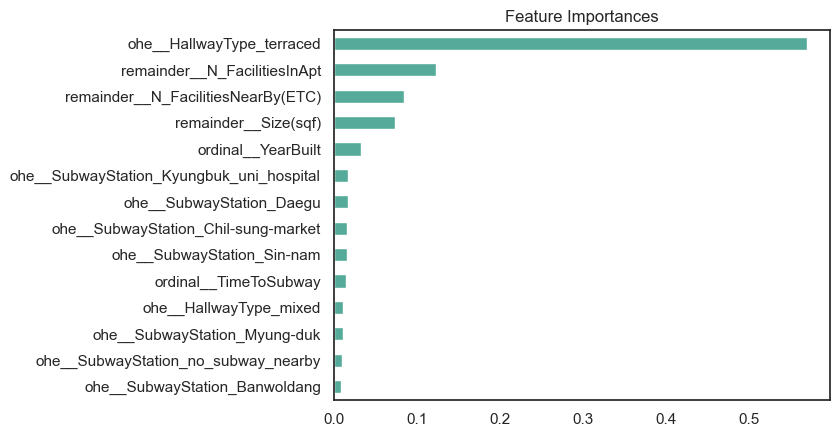

In [55]:
feature_imp = pd.Series(model_log_xgb_tuning.regressor_['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = True)

feature_imp.plot(kind='barh', title='Feature Importances')
plt.show()

Hallway Type (Terraced): The feature ohe__HallwayType_terraced has the highest importance by a significant margin. This suggests that the type of hallway (specifically, whether it is terraced) is a critical factor in the model's predictions. It could mean that apartments with a terraced hallway design have a substantial impact on the target variable (likely related to apartment value or desirability).

Number of Facilities in the Apartment: The features remainder__N_FacilitiesInApt and remainder__N_FacilitiesNearBy(ETC) also show high importance, indicating that the number of facilities either within the apartment complex or nearby (like shops, parks, etc.) plays a significant role. These features likely contribute to the overall appeal and value of the apartment.

Size (Square Footage): The feature remainder__Size(sqf) also has notable importance, which makes sense as the size of an apartment is typically a key determinant of its market value or desirability.

Year Built: The ordinal__YearBuilt feature has some importance, suggesting that the construction year of the apartment impacts its value. Generally, newer buildings may be more desirable due to better construction standards, modern amenities, and less wear and tear.

Proximity to Subway Stations: Multiple features related to proximity to different subway stations (e.g., ohe__SubwayStation_Kyungbuk_uni_hospital, ohe__SubwayStation_Daegu, etc.) have lower but still relevant importance. This indicates that the specific proximity to certain subway stations contributes to the model but is not as impactful as the type of hallway or number of facilities.

Overall Insights:
The hallway type (especially terraced) is the most critical factor, likely affecting the perception of space, light, or layout of the apartment.
Facilities in and around the apartment are significant, reflecting the importance of convenience and amenities in determining value.
Size and year built also play substantial roles, which are typical factors influencing real estate pricing.
Proximity to specific subway stations and the time to subway are important but secondary compared to the apartment's internal characteristics.

# Summary and Recommendation

## Summary
- The best model is XGB Tuning with TTR, evaluated using the metrics: MAE, MAPE, and MSLE. MAE is used to interpret the model, MAPE is used to show model accuracy, and MSLE is used to select the best model because the target variable has a wide range and a right-skewed distribution.
- The model yields the following metric values:
    - MAE: 31,572.33
    - MAPE: 0.16799
    - MSLE: 0.04633
- From the evaluation metrics, it can be inferred that the model predicts apartment prices with an error of approximately ±31,572 won (MAE) or an error of ±16.7% (MAPE) from the actual price. However, there is still a possibility of bias in the model's predictions, as indicated by the distribution of predicted vs. actual values and the residuals. This bias may be due to outliers in apartment prices within the data. A MAPE value between 10% and 20% is generally considered a good model (Stephen, 2022).
- The features that most significantly impact apartment prices are:
    - HallwayType, particularly the terraced type
    - N_FacilitiesInApt
    - N_FacilitiesNearBy(ETC)
    - Size(sqf)
    - YearBuilt

- The model's limitations, based on descriptive statistics, are that it may become biased if data outside the range of the minimum and maximum values for numerical variables is used or if data not present among the unique values of categorical variables is included.

In [56]:
display(df_prep.describe().loc[['min', 'max']],
        check_cat.drop('N Unique', axis=1))

,N_FacilitiesNearBy(ETC),N_FacilitiesInApt,Size(sqf),SalePrice,AverageMarketPrice,MarketPriceCompetitivenessScore,TotalFacilities,PricePerFacility
min,0.0,1.0,135.0,32743.0,87968.137931,0.198909,2.0,3919.071429
max,5.0,10.0,2337.0,585840.0,275839.729035,3.551161,14.0,104129.666667


,Name,Data Unique
0,HallwayType,"[corridor, mixed, terraced]"
1,TimeToSubway,"[0-5min, 10min~15min, 15min~20min, 5min~10min, no_bus_stop_nearby]"
2,SubwayStation,"[Bangoge, Banwoldang, Chil-sung-market, Daegu, Kyungbuk_uni_hospital, Myung-duk, Sin-nam, no_subway_nearby]"
3,YearBuilt,"[1978, 1980, 1985, 1986, 1992, 1993, 1997, 2003, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2015]"


- Model limitations based on the distribution of residuals and predictions: <br>
Focus on the feature range that results in predicted apartment prices below 200,000, as the residual outliers are fewer in this range, leading to potentially more accurate results.

In [57]:
# mencari nilai rentang fitur yang mendapakan harga prediksi < 200 ribu
limit = X_test.copy()
limit['y test'] = y_test
limit['y pred'] = y_pred_tuning
limit['residual'] = y_test - y_pred_tuning
limit = limit[limit['y pred'] < 200000]

limit['YearBuilt'] = limit['YearBuilt'].astype('str')
object_col = limit.columns[limit.dtypes == object]

listItem = []
for col in limit[object_col].columns :
    listItem.append( [col, limit[col].nunique(), limit.sort_values(col)[col].unique()])

kategorik_unique = pd.DataFrame(columns=['Nama', 'Jumlah Data Unique', 'Data Unique'],
                     data=listItem)        

display(limit[['N_FacilitiesNearBy(ETC)','N_FacilitiesInApt','Size(sqf)']].describe().loc[['min', 'max']], 
        kategorik_unique)

,N_FacilitiesNearBy(ETC),N_FacilitiesInApt,Size(sqf)
min,0.0,1.0,135.0
max,5.0,9.0,1451.0


,Nama,Jumlah Data Unique,Data Unique
0,HallwayType,3,"[corridor, mixed, terraced]"
1,TimeToSubway,4,"[0-5min, 10min~15min, 15min~20min, 5min~10min]"
2,SubwayStation,8,"[Bangoge, Banwoldang, Chil-sung-market, Daegu, Kyungbuk_uni_hospital, Myung-duk, Sin-nam, no_subway_nearby]"
3,YearBuilt,12,"[1978, 1980, 1985, 1986, 1992, 1993, 1997, 2003, 2005, 2006, 2013, 2014]"


## Recommendation

**Model**
- Identify features or characteristics that better represent the apartment prices, as many apartments have identical feature values, which may appear as duplicate data even though the data is valid. This indicates that the current features may not adequately represent apartment prices.
- Rebuild the model based on the findings from feature importance analysis.
- Perform hyperparameter tuning again using the updated model based on feature importance, and compare the results with the current model.
- Identify apartment data with high prices (above the upper bound of the IQR) to address skewness in the target variable.
- Update the dataset whenever new apartment price data becomes available.

**Company**
- Perform a trial prediction of the apartment price using the developed model to avoid incurring costs for a third party. Assuming the cost for a third party is 10,000 won, using the model could save this amount.
- Use the model to assist in setting the apartment sale price, ensuring that the price is appropriate and aligned with market conditions.

**Overprice Sumulation**

In [58]:
resid.iloc[1]

y_aktual      184955.0
y_prediksi    168524.0
residual       16431.0
Name: 1, dtype: float64

As shown in the results above, the actual price of the apartment is 184,955 won, while the predicted price is 168,524 won. This indicates that the actual price is overpriced based on this dataset, suggesting a potential risk that the apartment may not sell due to being less competitive with the existing market prices.

**Underprice Sumulation**

In [59]:
resid.iloc[2]

y_aktual      70796.0
y_prediksi    78025.0
residual      -7229.0
Name: 2, dtype: float64

As shown in the results above, the actual price of the apartment is 184,955 won, while the predicted price is 168,524 won. This indicates that the actual price is overpriced based on this dataset, suggesting a potential risk that the apartment may not sell due to being less competitive with the existing market prices.

## Experiment Using All Features <br>

Decision trees and boosted tree algorithms are immune to multicollinearity [(Will, 2019)](https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4#:~:text=Multicollinearity%20happens%20when%20one%20predictor,immune%20to%20multicollinearity%20by%20nature%20.). Therefore, since the previous model only used selected features based on VIF checks, this time, the modeling will utilize all available features.


In [60]:
X2 = df.drop('SalePrice', axis=1)
y2 = df['SalePrice']

X2_trainval, X2_test, y2_trainval, y2_test = train_test_split(
    X2,
    y2,
    test_size=0.2,
    random_state=42
)

In [61]:
grid_model_tuning.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['HallwayType',
                                                   'SubwayStation']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
15min~20min           3
dtype: int64},
                                                                          {'col': 'YearBuilt',
                                                                           'data_type': dtype('O'),
                                                                           'mappin...
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [62]:
model2_log_xgb_tuning = TransformedTargetRegressor(grid_model_tuning.best_estimator_,func=np.log, inverse_func=np.exp)

model2_log_xgb_tuning.fit(X2_trainval, y2_trainval)
y2_pred_tuning = model2_log_xgb_tuning.predict(X2_test)

hasil2_pred_tuning = pd.DataFrame()
hasil2_pred_tuning['Model'] = ['XGB  Tuning with TTR All Feature']
hasil2_pred_tuning['MAE'] = [mean_absolute_error(y2_test, y2_pred_tuning)]
hasil2_pred_tuning['MAPE'] = [mean_absolute_percentage_error(y2_test, y2_pred_tuning)]
hasil2_pred_tuning['MSLE'] = [mean_squared_log_error(y2_test, y2_pred_tuning)]

display(hasil2_pred_tuning, y2_pred_tuning)

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR All Feature,31622.172448,0.168195,0.046464


array([293909.53 , 167475.45 ,  77548.99 , 405416.44 , 189979.72 ,
       189979.72 , 148751.62 , 215270.9  ,  76284.695, 225946.5  ,
       367606.3  , 100029.82 , 289095.25 , 214498.12 , 175577.73 ,
       251191.16 , 100029.82 , 236079.19 , 210800.98 , 396142.88 ,
        52179.547, 157369.   , 148751.62 , 225946.5  ,  82519.53 ,
       201907.84 , 309016.97 , 272158.03 , 346800.2  , 329508.53 ,
       235502.84 , 148751.62 , 100393.94 , 272158.03 , 346800.2  ,
        78525.62 , 274371.6  ,  82035.555, 251191.16 ,  93829.26 ,
       260619.69 , 148751.62 , 214498.12 , 338764.97 ,  81990.664,
       151949.56 , 100029.82 , 160991.23 , 222146.08 , 278398.56 ,
       157369.   , 230657.03 , 282029.1  , 113563.96 , 100393.94 ,
       241319.95 , 260619.69 , 346800.2  , 454628.12 , 222146.08 ,
       189979.72 , 293909.53 , 260619.69 , 260619.69 , 201907.84 ,
       157369.   , 113563.96 , 210800.98 , 292715.1  , 401999.53 ,
       167475.45 , 201907.84 , 175577.73 , 157369.   , 336149.

In [63]:
display(hasil2_pred_tuning,
        hasil_pred_tuning)

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR All Feature,31622.172448,0.168195,0.046464


,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR,31572.332027,0.167993,0.046331


It can be observed that the model using all features has higher metric values compared to the model that does not use all features. Thus, the performance of the model using all features is less favorable.

# Deployment

In [64]:
grid_model_tuning.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['HallwayType',
                                                   'SubwayStation']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
15min~20min           3
dtype: int64},
                                                                          {'col': 'YearBuilt',
                                                                           'data_type': dtype('O'),
                                                                           'mappin...
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [65]:
# # save model

# model = TransformedTargetRegressor(grid_model_tuning.best_estimator_,func=np.log, inverse_func=np.exp)
# model.fit(X_trainval, y_trainval)

# filename = 'Apartment Model.sav'
# pickle.dump(model, open(filename, 'wb')) # wb untuk nyimpan model # rb untuk memanggil model

In [66]:
# # load model
# filename = 'Apartment Model.sav'
# loaded_model = pickle.load(open(filename, 'rb'))
# loaded_model

In [67]:
# print('MAE = {}'.format(mean_absolute_error(y_test, loaded_model.predict(X_test))))
# print('MAPE = {}'.format(mean_absolute_percentage_error(y_test, loaded_model.predict(X_test))))
# print('MSLE = {}'.format(mean_squared_log_error(y_test, loaded_model.predict(X_test))))

# hasil_pred_tuning